# AISE4010- Project - Traffic Congestion
#### Group 7:
Aaron Triguero, Khen Agnes (Burger From Harveys), Shiv Pi Patel

---

*With an increasing number of vehicles on the road, managing urban congestions becomes increasingly difficult, leading to increased fuel consumption and carbon emissions.*

*Goal: To predict traffic congestions periods allowing commuters to optimize their travel strategies, allowing for more efficient transportation systems.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from time import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# directory to data files
dir = 'drive/MyDrive/Colab Notebooks/4010 T7 Project/data/'   # aaron
# dir = 'drive/MyDrive/Colab Notebooks/4010 T7 Project/data/'    # [insert your own]

Mounted at /content/drive


## View raw files for each variable
- speed, occupancy, travel time
  - for each of the two "complete" datasets we have

                     Occupancy
timestamp                     
2015-09-01 11:30:00      13.56
2015-09-01 11:35:00       8.33
2015-09-01 11:40:00      11.78
2015-09-01 11:55:00      15.28
2015-09-01 12:00:00      10.06


<Axes: xlabel='timestamp', ylabel='average # cars'>

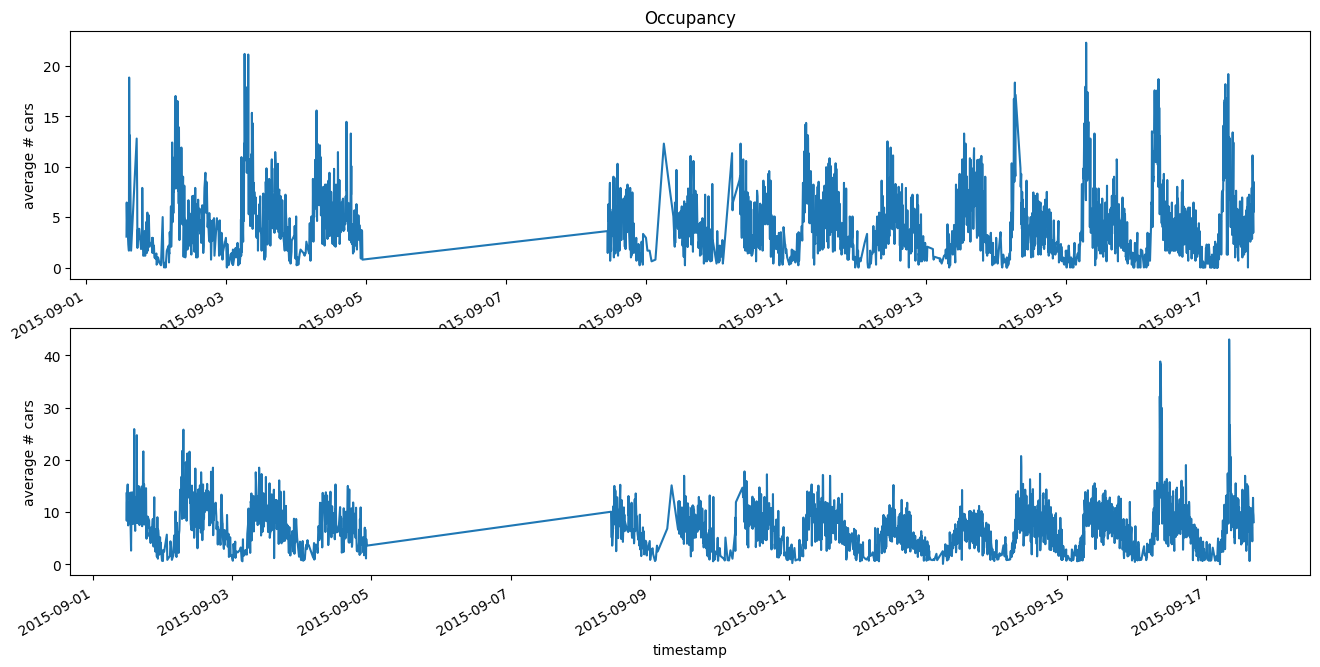

In [ ]:
# Load Occupancy dataset
df_o1 = pd.read_csv(dir+'occupancy_6005.csv').rename(columns={'value':'Occupancy'})
df_o2 = pd.read_csv(dir+'occupancy_t4013.csv').rename(columns={'value':'Occupancy'})

# Set index
df_o1['timestamp'] = pd.to_datetime(df_o1['timestamp'])   # to datetime
df_o2['timestamp'] = pd.to_datetime(df_o2['timestamp'])
df_o1 = df_o1.set_index('timestamp')
df_o2 = df_o2.set_index('timestamp')
print(df_o2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_o1['Occupancy'].plot(ylabel='average # cars',title='Occupancy')
plt.subplot(2, 1, 2)
df_o2['Occupancy'].plot(ylabel='average # cars')

                     Travel Time
timestamp                       
2015-07-28 11:56:00          248
2015-07-28 12:06:00          178
2015-07-28 12:25:00          155
2015-07-28 13:56:00          121
2015-07-28 14:06:00          103


<Axes: xlabel='timestamp', ylabel='seconds'>

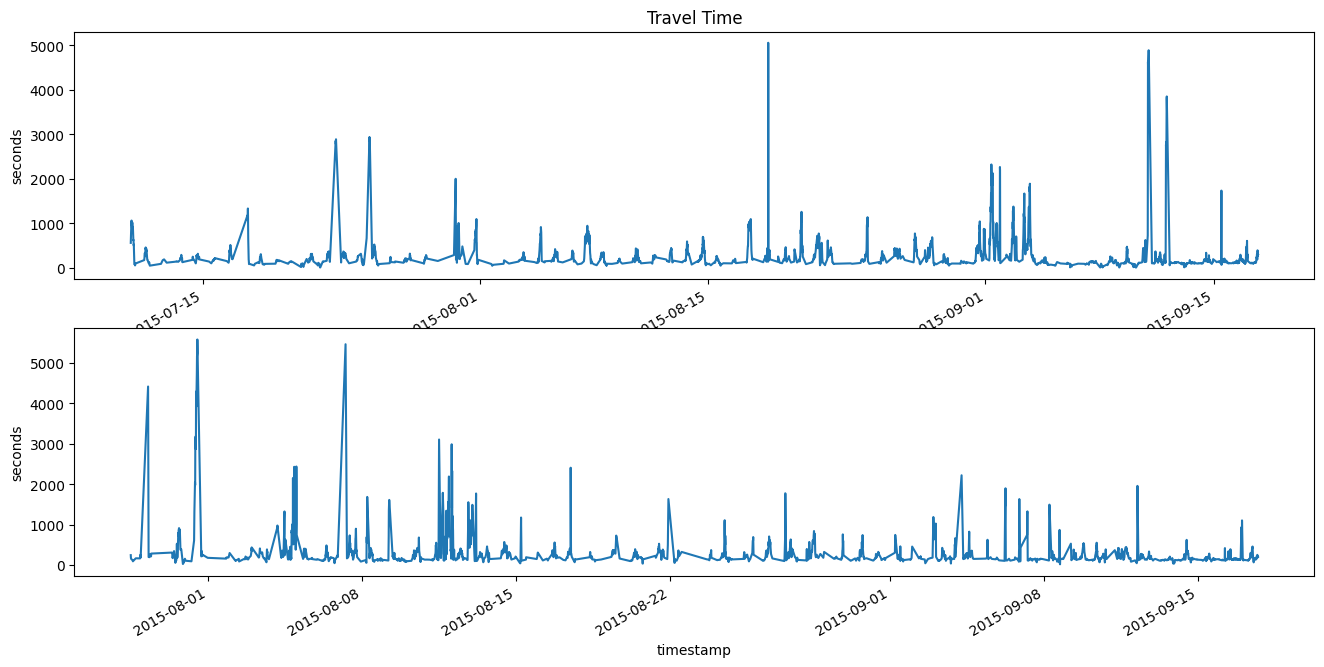

In [ ]:
# Load TravelTime dataset
df_t1 = pd.read_csv(dir+'TravelTime_387.csv').rename(columns={'value':'Travel Time'})
df_t2 = pd.read_csv(dir+'TravelTime_451.csv').rename(columns={'value':'Travel Time'})

# Set index
df_t1['timestamp'] = pd.to_datetime(df_t1['timestamp'])   # to datetime
df_t2['timestamp'] = pd.to_datetime(df_t2['timestamp'])
df_t1 = df_t1.set_index('timestamp')
df_t2 = df_t2.set_index('timestamp')
print(df_t2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_t1['Travel Time'].plot(ylabel='seconds',title='Travel Time')
plt.subplot(2, 1, 2)
df_t2['Travel Time'].plot(ylabel='seconds')

                     Speed
timestamp                 
2015-09-01 11:25:00     58
2015-09-01 11:30:00     63
2015-09-01 11:35:00     63
2015-09-01 11:40:00     64
2015-09-01 11:55:00     58


<Axes: xlabel='timestamp', ylabel='km/h'>

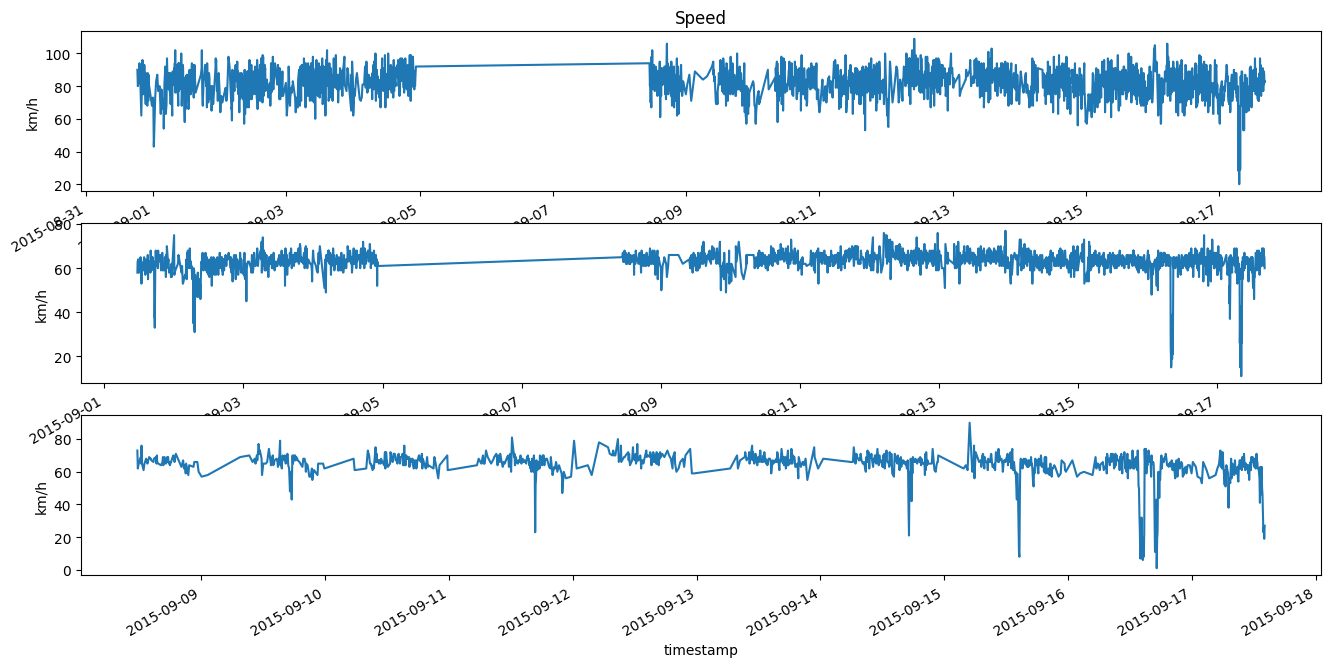

In [ ]:
# Load speed dataset
df_s1 = pd.read_csv(dir+'speed_6005.csv').rename(columns={'value':'Speed'})
df_s2 = pd.read_csv(dir+'speed_t4013.csv').rename(columns={'value':'Speed'})
df_s3 = pd.read_csv(dir+'speed_7578.csv').rename(columns={'value':'Speed'})

# Set index
df_s1['timestamp'] = pd.to_datetime(df_s1['timestamp'])   # to datetime
df_s2['timestamp'] = pd.to_datetime(df_s2['timestamp'])
df_s3['timestamp'] = pd.to_datetime(df_s3['timestamp'])
df_s1 = df_s1.set_index('timestamp')
df_s2 = df_s2.set_index('timestamp')
df_s3 = df_s3.set_index('timestamp')
print(df_s2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(3, 1, 1)
df_s1['Speed'].plot(ylabel='km/h',title='Speed')
plt.subplot(3, 1, 2)
df_s2['Speed'].plot(ylabel='km/h')
plt.subplot(3, 1, 3)
df_s3['Speed'].plot(ylabel='km/h')

## 1. Preprocess Data

- Preprocess by joining data, resampling, and normalizing
- Get time series components of each variable
- Split into training, testing sets

#### Joining, Resampling and Normalizing

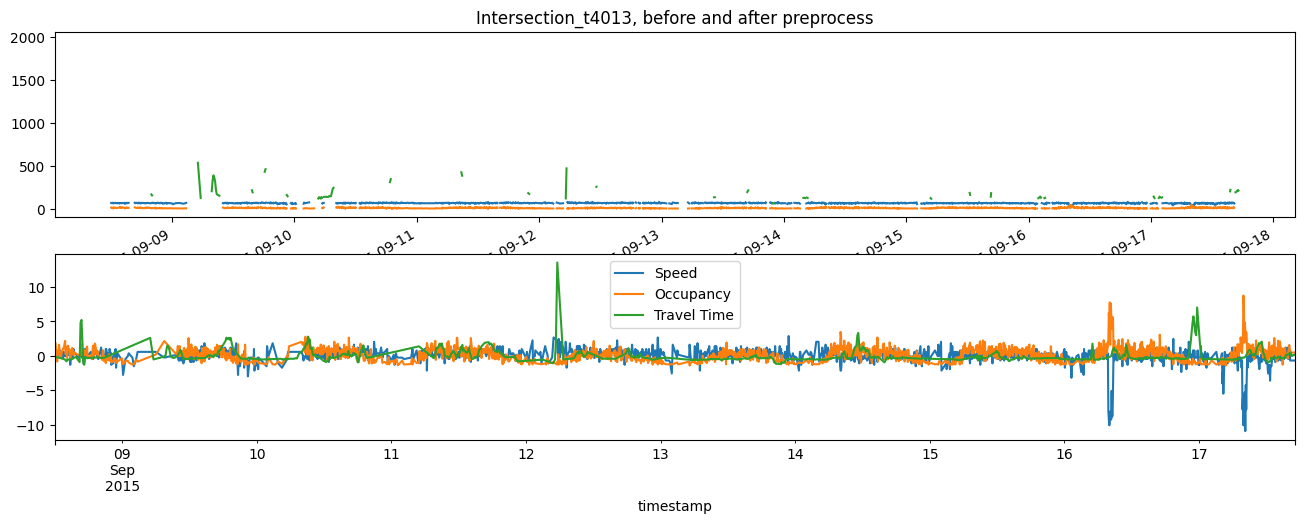

In [ ]:
# Dataset for intersection 6005
# data_6005 = df_o1.join(df_t1, how='outer').join(df_s1, how='outer')
# data_6005 = data_6005['2015-09-09':]  # take only data after certain date             # if we wanted to do 2 intersections

# Dataset for intersection t4013
data_t4013 = df_o2.join(df_t2, how='outer').join(df_s2, how='outer')
data = data_t4013['2015-09-08 12':]  # take only data after certain date



# Plot data before resampling
plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
data['Speed'].plot(title='Intersection_t4013, before and after preprocess')#, ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()


# Data after resampling (using mean) to 5 min intervals
# and handling missing data using _______(interpolation)________
data = data.resample('5min').mean()
data = data.interpolate()

data['Travel Time'] = data['Travel Time'].bfill()   # special case where Travel Time has few initial data points missing

# Normalize each variable using StandardScaler
scaler_s, scaler_o, scaler_t = StandardScaler(), StandardScaler(), StandardScaler()
data['Speed'] = scaler_s.fit_transform(data[['Speed']])
data['Occupancy'] = scaler_o.fit_transform(data[['Occupancy']])
data['Travel Time'] = scaler_t.fit_transform(data[['Travel Time']])


# Plot data after preprocessing
plt.subplot(2,1,2)
data['Speed'].plot()#ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()
plt.legend()
plt.show()


In [ ]:
data.shape    # (2510 timesteps, 3 variables)

(2654, 3)

#### Components of the time series

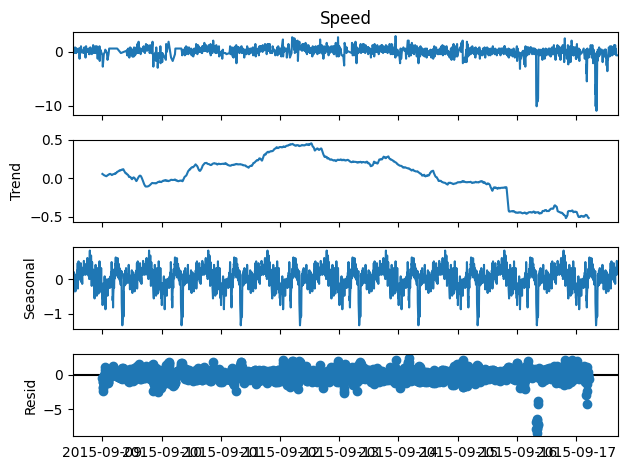

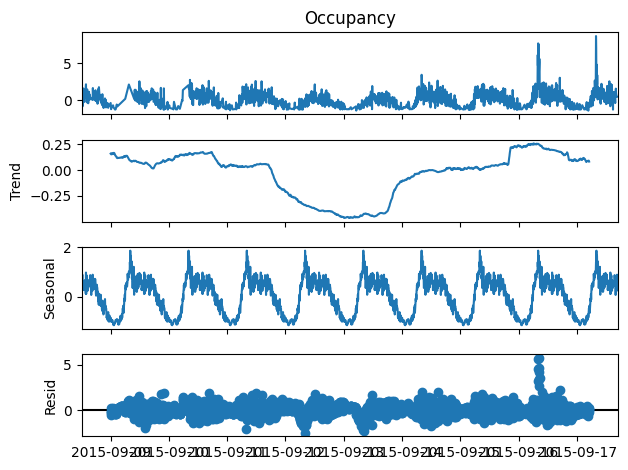

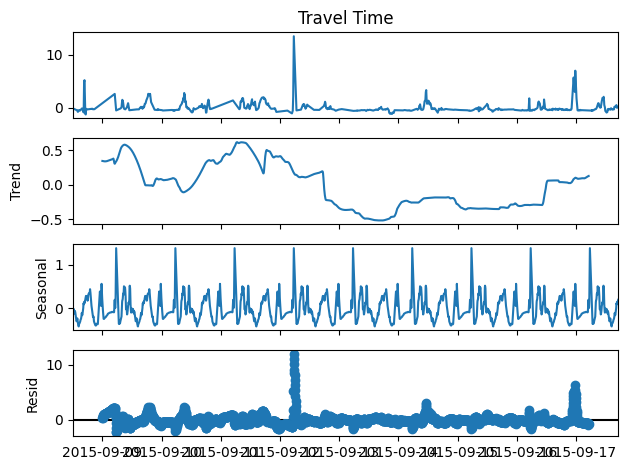

In [ ]:
# check seasonality, trends, etc for each variable

result_speed = seasonal_decompose(data['Speed'], model='additive', period=288)  # 12 5-min intervals per hour, expect daily patterns (12 * 24 = 288)
result_speed.plot()
plt.show()

result_occupancy = seasonal_decompose(data['Occupancy'], model='additive', period=288)
result_occupancy.plot()
plt.show()

result_ttime = seasonal_decompose(data['Travel Time'], model='additive', period=288)
result_ttime.plot()
plt.show()


#### Splitting train and test sets

In [ ]:
# Sliding window to split data

def sliding_window(data, n):
    # data: original data
    # n: window size
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data[i:(i + n)])
        y.append(data[i + n])
    return np.array(X), np.array(y)


# For n timesteps
n_steps = 12      # each 60 minutes (5 minutes per timestep)

# Each variable
Xo, yo = sliding_window(data['Occupancy'], n_steps)
Xs, ys = sliding_window(data['Speed'], n_steps)
Xt, yt = sliding_window(data['Travel Time'], n_steps)

# Split data into training testing sets
split = int(len(Xo)*0.8)

Xo_train, Xo_test = Xo[:split], Xo[split:]
yo_train, yo_test = yo[:split], yo[split:]

Xs_train, Xs_test = Xs[:split], Xs[split:]
ys_train, ys_test = ys[:split], ys[split:]

Xt_train, Xt_test = Xt[:split], Xt[split:]
yt_train, yt_test = yt[:split], yt[split:]

# Reshape (samples, time_steps, feature)
Xo_train = Xo_train.reshape(Xo_train.shape[0], Xo_train.shape[1], 1)
Xo_test = Xo_test.reshape(Xo_test.shape[0], Xo_test.shape[1], 1)

Xs_train = Xs_train.reshape(Xs_train.shape[0], Xs_train.shape[1], 1)
Xs_test = Xs_test.reshape(Xs_test.shape[0], Xs_test.shape[1], 1)

Xt_train = Xt_train.reshape(Xt_train.shape[0], Xt_train.shape[1], 1)
Xt_test = Xt_test.reshape(Xt_test.shape[0], Xt_test.shape[1], 1)


<ipython-input-11-fcacbab232db>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + n])


## 2. Model: Training & Testing

- Here we create the models (CNN, RNN, LSTM, GRU) for each variable
- Then train each variable on each model.
- Afterwards, we test each model and get performance.

### CNN Model
Make the model:

In [ ]:
# CNN model
model_CNN = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Optimizer and loss fn
model_CNN.compile(optimizer='adam', loss='mean_squared_error')

# Copy models for each variable
model_CNN_s, model_CNN_o, model_CNN_t = model_CNN, model_CNN, model_CNN

# Choose parameters for training
EPOCHS = 40
BATCH_SIZE = 32
VAL_SPLIT = 0.2



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Training using CNN models

Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4599 - val_loss: 0.3420
Epoch 2/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3196 - val_loss: 0.3284
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3063 - val_loss: 0.3094
Epoch 4/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3075 - val_loss: 0.3200
Epoch 5/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3141 - val_loss: 0.3183
Epoch 6/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2585 - val_loss: 0.3188
Epoch 7/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2968 - val_loss: 0.3153
Epoch 8/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2783 - val_loss: 0.3272
Epoch 9/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2493 - val_loss: 0.3173
Epoch 10/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2704 - val_loss: 0.3182
Epoch 11/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2722 - val_loss: 0.3130
Epoch 12/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2815 - val_lo

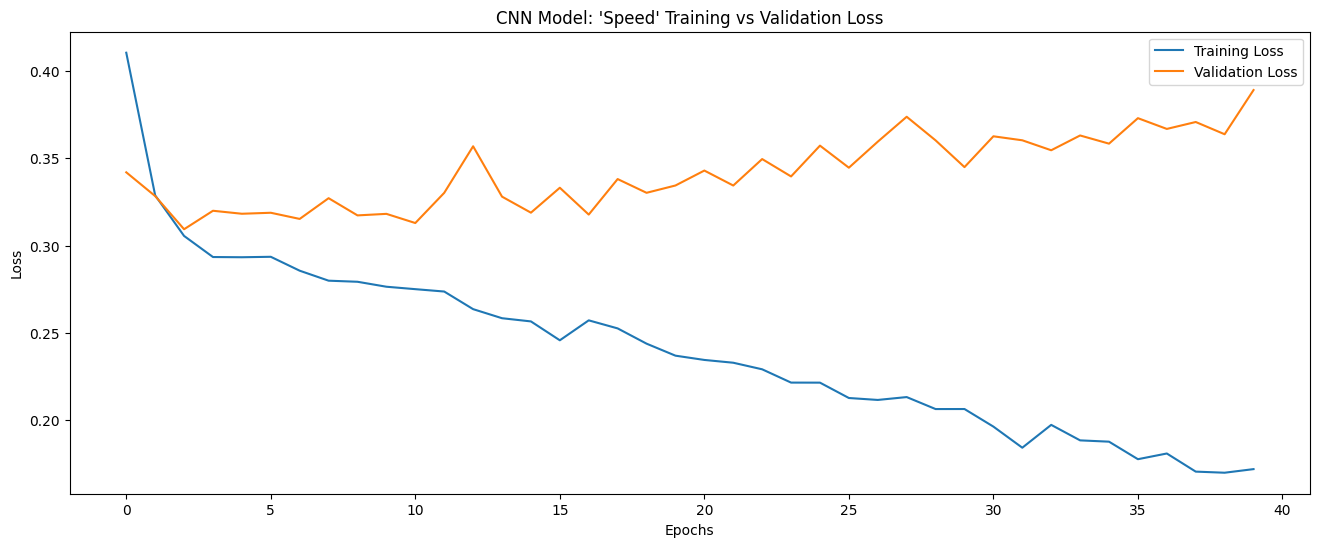

CNN Training Time for 'Speed': 21.684 seconds


In [ ]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")


Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3132 - val_loss: 0.4269
Epoch 2/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2661 - val_loss: 0.4127
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - val_loss: 0.4177
Epoch 4/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2465 - val_loss: 0.4176
Epoch 5/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2287 - val_loss: 0.4280
Epoch 6/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2241 - val_loss: 0.4347
Epoch 7/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2322 - val_loss: 0.4202
Epoch 8/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2199 - val_loss: 0.4251
Epoch 9/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2322 - val_loss: 0.4246
Epoch 10/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2103 - val_loss: 0.4207
Epoch 11/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1944 - val_loss: 0.4295
Epoch 12/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1896 - val_lo

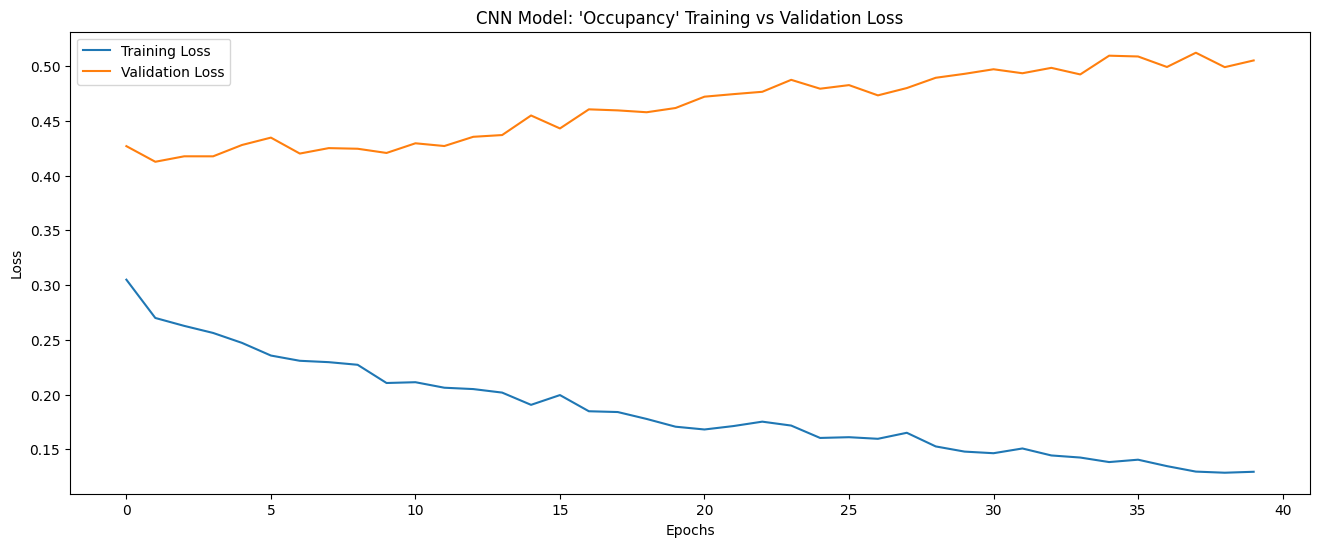

CNN Training Time for 'Occupancy': 8.107 seconds


In [ ]:
# Occupancy data
start_time = time()
cnn_history_occupancy = model_CNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(cnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(cnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Occupancy\': {cnn_time_occupancy:.3f} seconds")

Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2579 - val_loss: 0.0700
Epoch 2/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1982 - val_loss: 0.0298
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1225 - val_loss: 0.0276
Epoch 4/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0954 - val_loss: 0.0259
Epoch 5/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0671 - val_loss: 0.0334
Epoch 6/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1114 - val_loss: 0.0322
Epoch 7/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0983 - val_loss: 0.0220
Epoch 8/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0511 - val_loss: 0.0211
Epoch 9/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0833 - val_loss: 0.0204
Epoch 10/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0640 - val_loss: 0.0256
Epoch 11/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0780 - val_loss: 0.0275
Epoch 12/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0633 - val_lo

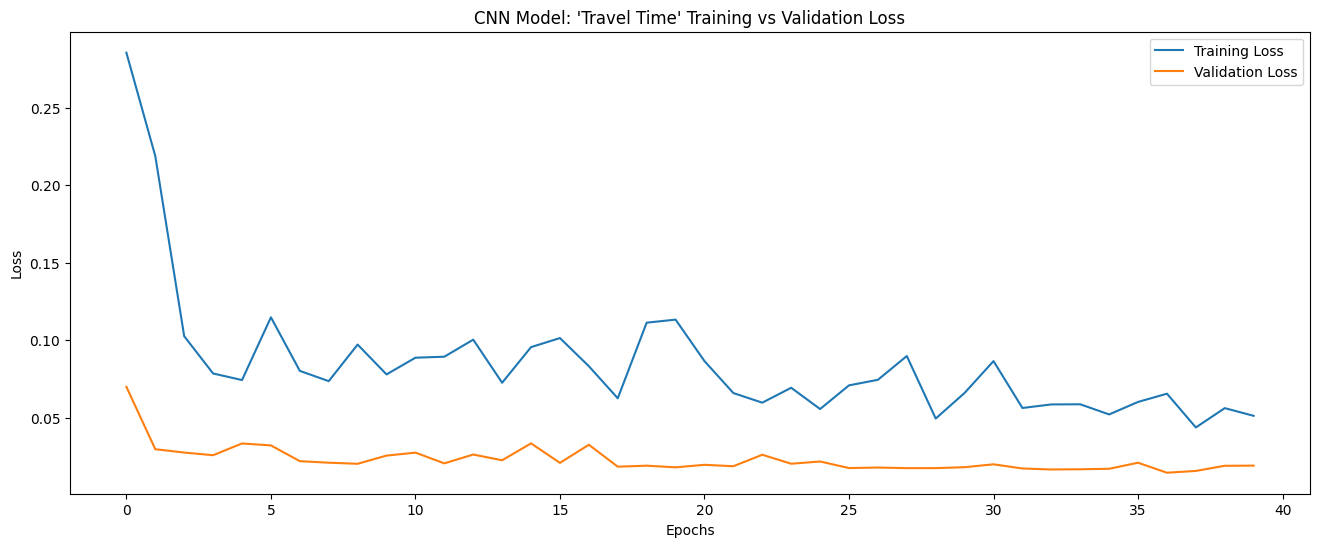

CNN Training Time for 'Travel Time': 7.188 seconds


In [ ]:
# Travel Time data
start_time = time()
cnn_history_ttime = model_CNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(cnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(cnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Travel Time\': {cnn_time_ttime:.3f} seconds")


#### Predicting using CNN models

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN Test: 'Speed' RMSE: 5.7980857360910685
CNN Test: 'Speed' MAE: 3.347085005797708


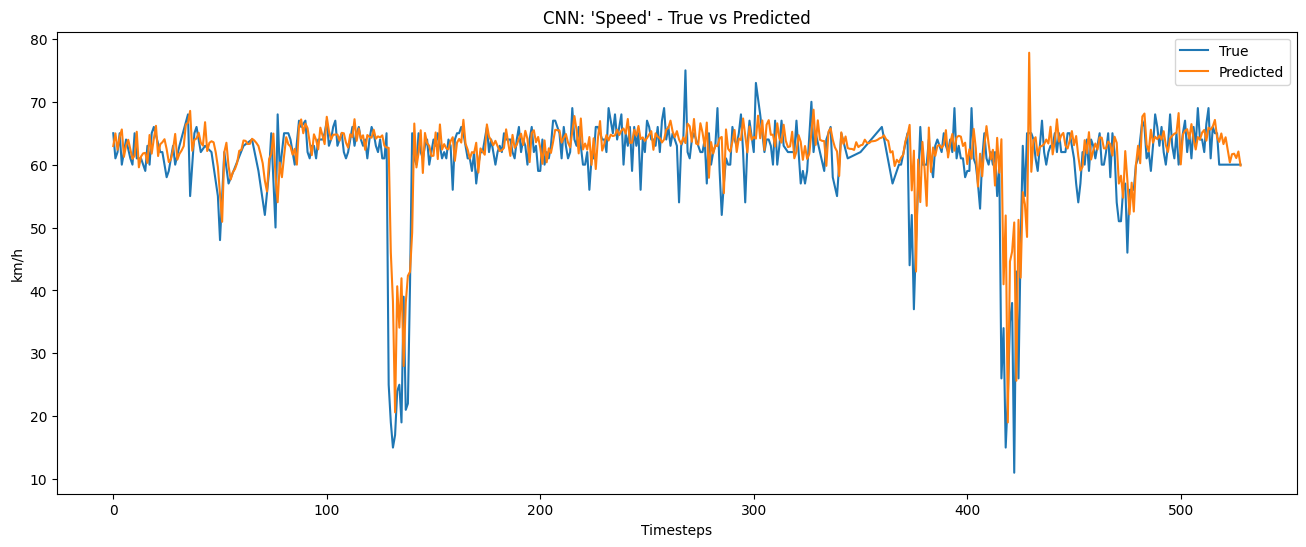

In [ ]:
# Evaluate and plot predictions
ys_pred_cnn = model_CNN_s.predict(Xs_test)
# Rescale to original units
ys_test_rescale = scaler_s.inverse_transform(ys_test.reshape(-1, 1))
ys_pred_cnn_rescale = scaler_s.inverse_transform(ys_pred_cnn)
# Calculate RMSE and MAE
cnn_rmse_s = np.sqrt(mean_squared_error(ys_test_rescale, ys_pred_cnn_rescale))
cnn_mae_s = mean_absolute_error(ys_test_rescale, ys_pred_cnn_rescale)

print(f'CNN Test: \'Speed\' RMSE: {cnn_rmse_s}')
print(f'CNN Test: \'Speed\' MAE: {cnn_mae_s}')

plt.figure(figsize=(16,6))
plt.plot(ys_test_rescale, label='True')
plt.plot(ys_pred_cnn_rescale, label='Predicted')
plt.title('CNN: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CNN Test: 'Occupancy' RMSE: 1.021645744017295
CNN Test: 'Occupancy' MAE: 0.6737250566336208


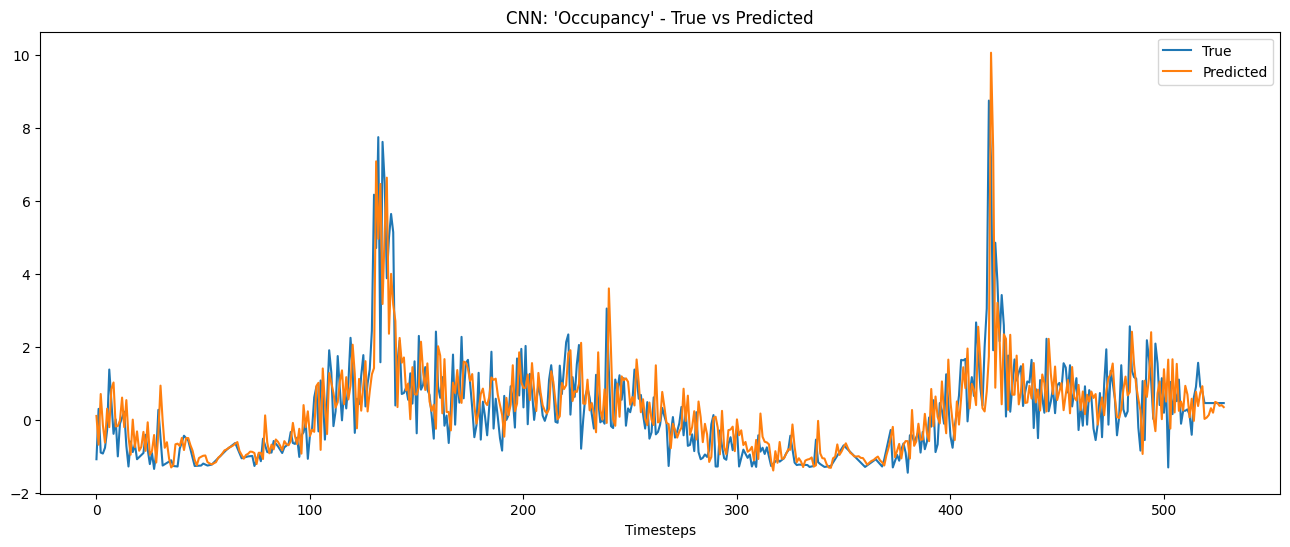

In [ ]:
# Evaluate and plot predictions
yo_pred_cnn = model_CNN_o.predict(Xo_test)
# Rescale to original units
yo_test_rescale = scaler_o.inverse_transform(yo_test.reshape(-1, 1))
yo_pred_cnn_rescale = scaler_o.inverse_transform(yo_pred_cnn)
# Calculate RMSE and MAE
cnn_rmse_o = np.sqrt(mean_squared_error(yo_test_rescale, yo_pred_cnn_rescale))
cnn_mae_o = mean_absolute_error(yo_test_rescale, yo_pred_cnn_rescale)

print(f'CNN Test: \'Occupancy\' RMSE: {cnn_rmse_o}')
print(f'CNN Test: \'Occupancy\' MAE: {cnn_mae_o}')

plt.figure(figsize=(16,6))
plt.plot(yo_test_rescale, label='True')
plt.plot(yo_pred_cnn_rescale, label='Predicted')
plt.title('CNN: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CNN Test: 'Travel Time' RMSE: 0.2658453775855068
CNN Test: 'Travel Time' MAE: 0.10456729403493313


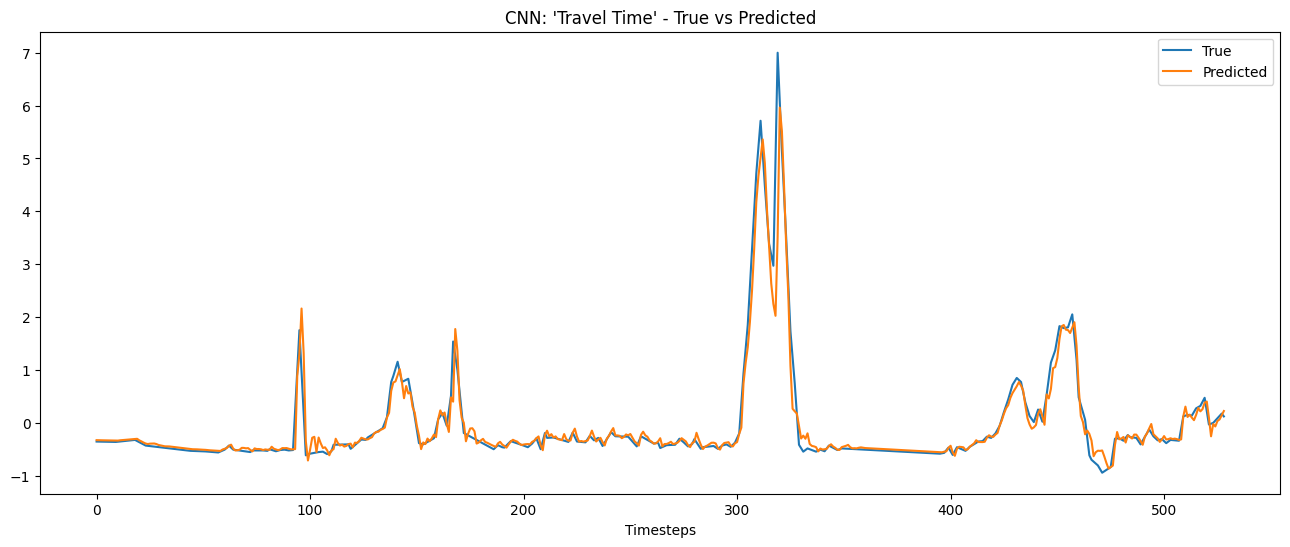

In [ ]:
# Evaluate and plot predictions
yt_pred_cnn = model_CNN_t.predict(Xt_test)
# Rescale to original units
yt_test_rescale = scaler_t.inverse_transform(yt_test.reshape(-1, 1))
yt_pred_cnn_rescale = scaler_t.inverse_transform(yt_pred_cnn)
# Calculate RMSE and MAE
cnn_rmse_t = np.sqrt(mean_squared_error(yt_test_rescale, yt_pred_cnn_rescale))
cnn_mae_t = mean_absolute_error(yt_test_rescale, yt_pred_cnn_rescale)

print(f'CNN Test: \'Travel Time\' RMSE: {cnn_rmse_t}')
print(f'CNN Test: \'Travel Time\' MAE: {cnn_mae_t}')

plt.figure(figsize=(16,6))
plt.plot(yt_test_rescale, label='True')
plt.plot(yt_pred_cnn_rescale, label='Predicted')
plt.title('CNN: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

### RNN Model
Make the model:

In [ ]:
# RNN model
model_RNN = Sequential([
    SimpleRNN(40, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Dense(1)
])

# Optimizer and loss fn
model_RNN.compile(optimizer='adam', loss='mean_squared_error')

# Copy models for each variable
model_RNN_s, model_RNN_o, model_RNN_t = model_RNN, model_RNN, model_RNN

# Choose parameters for training
EPOCHS = 50
BATCH_SIZE = 16
VAL_SPLIT = 0.2


#### Training using RNN models

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3435 - val_loss: 0.3126
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2847 - val_loss: 0.3143
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2763 - val_loss: 0.3089
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2743 - val_loss: 0.3099
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3173 - val_loss: 0.3168
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2749 - val_loss: 0.3229
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2683 - val_loss: 0.3030
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2582 - val_loss: 0.3071
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2769 - val_loss: 0.3224
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2610 - val_loss: 0.3075
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2539 - val_loss: 0.3192
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

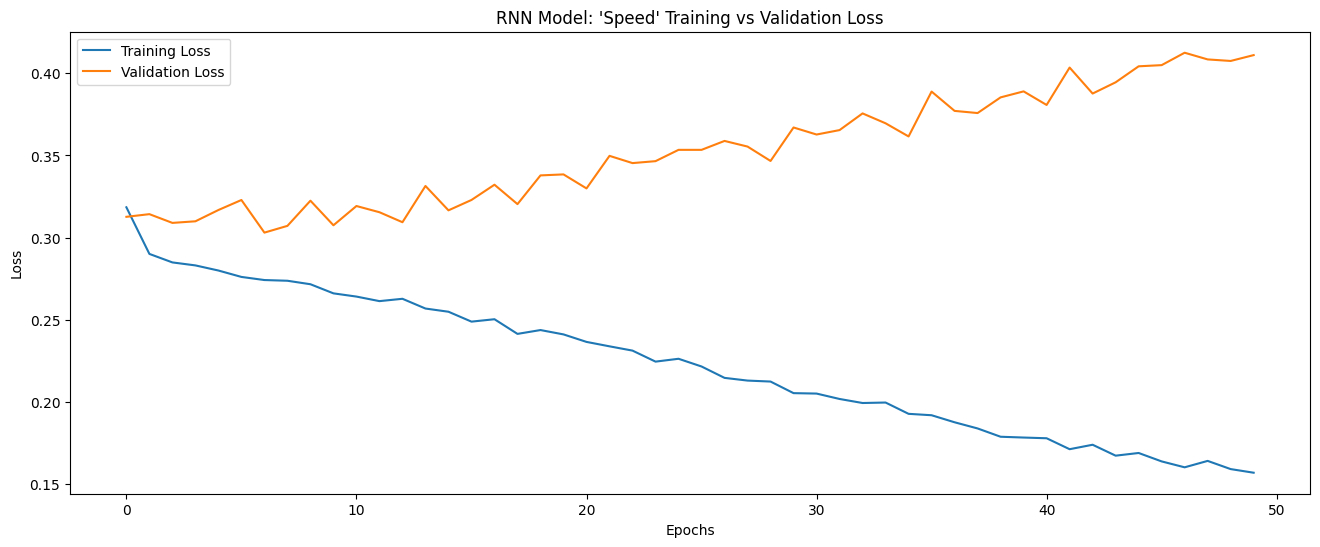

RNN Training Time for 'Speed': 32.725 seconds


In [ ]:
# Speed data
start_time = time()
rnn_history_speed = model_RNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(rnn_history_speed.history['loss'], label='Training Loss')
plt.plot(rnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Speed\': {rnn_time_speed:.3f} seconds")


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3558 - val_loss: 0.4407
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2593 - val_loss: 0.4324
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2598 - val_loss: 0.4148
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2548 - val_loss: 0.4079
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2478 - val_loss: 0.4124
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2387 - val_loss: 0.4130
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2414 - val_loss: 0.4180
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2328 - val_loss: 0.4042
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2115 - val_loss: 0.4119
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2084 - val_loss: 0.4057
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2117 - val_loss: 0.4069
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

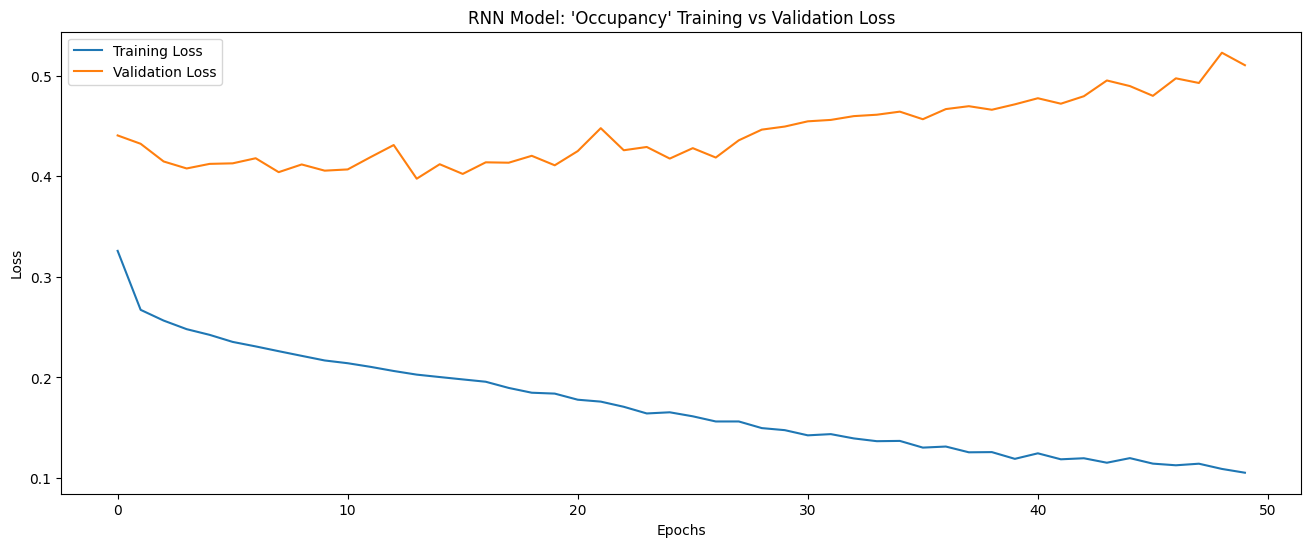

RNN Training Time for 'Occupancy': 28.010 seconds


In [ ]:
# Occupancy data
start_time = time()
rnn_history_occupancy = model_RNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(rnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(rnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Occupancy\': {rnn_time_occupancy:.3f} seconds")

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2233 - val_loss: 0.0119
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - val_loss: 0.0118
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0325 - val_loss: 0.0126
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0321 - val_loss: 0.0123
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0285 - val_loss: 0.0126
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0335 - val_loss: 0.0121
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0263 - val_loss: 0.0120
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - val_loss: 0.0123
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0218 - val_loss: 0.0123
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0285 - val_loss: 0.0117
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0337 - val_loss: 0.0121
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

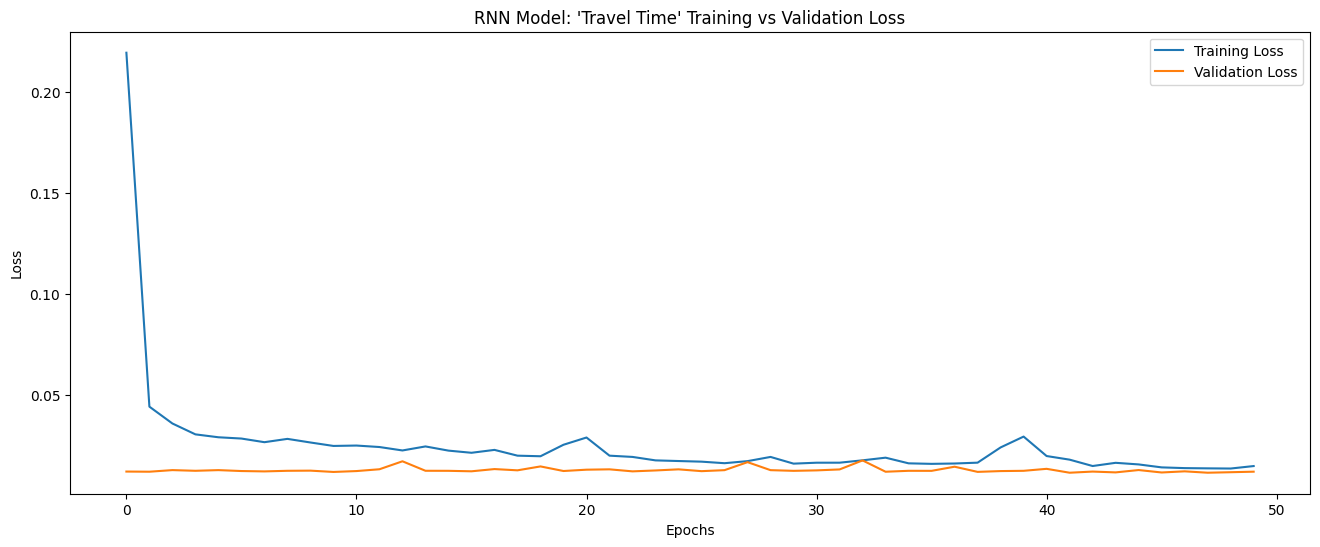

RNN Training Time for 'Travel Time': 27.045 seconds


In [ ]:
# Travel Time data
start_time = time()
rnn_history_ttime = model_RNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(rnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(rnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Travel Time\': {rnn_time_ttime:.3f} seconds")


#### Predicting using RNN Models

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
RNN Test: 'Speed' RMSE: 1.5564171528311264
RNN Test: 'Speed' MAE: 0.9743871238495365


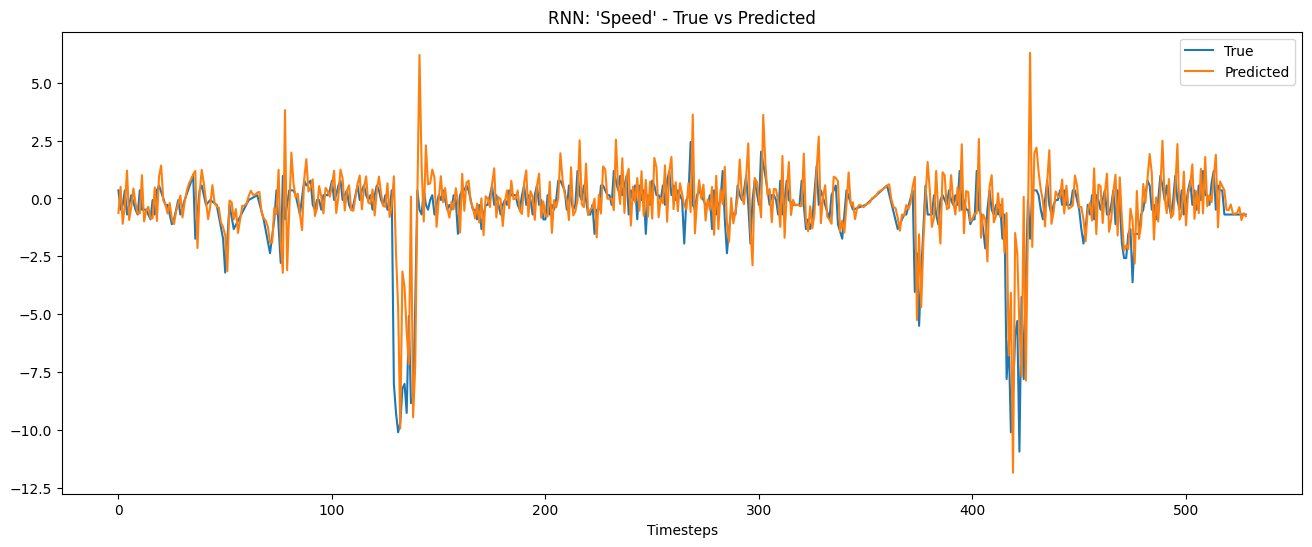

In [ ]:
# Evaluate and plot predictions
ys_pred_rnn = model_RNN_s.predict(Xs_test)
# Rescale to original units
ys_pred_rnn_rescale = scaler_s.inverse_transform(ys_pred_rnn)
# Calculate RMSE and MAE
rnn_rmse_s = np.sqrt(mean_squared_error(ys_test_rescale, ys_pred_rnn_rescale))
rnn_mae_s = mean_absolute_error(ys_test_rescale, ys_pred_rnn_rescale)

print(f'RNN Test: \'Speed\' RMSE: {rnn_rmse_s}')
print(f'RNN Test: \'Speed\' MAE: {rnn_mae_s}')

plt.figure(figsize=(16,6))
plt.plot(ys_test_rescale, label='True')
plt.plot(ys_pred_rnn_rescale, label='Predicted')
plt.title('RNN: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RNN Test: 'Occupancy' RMSE: 1.3562731069675522
RNN Test: 'Occupancy' MAE: 0.8901361908930516


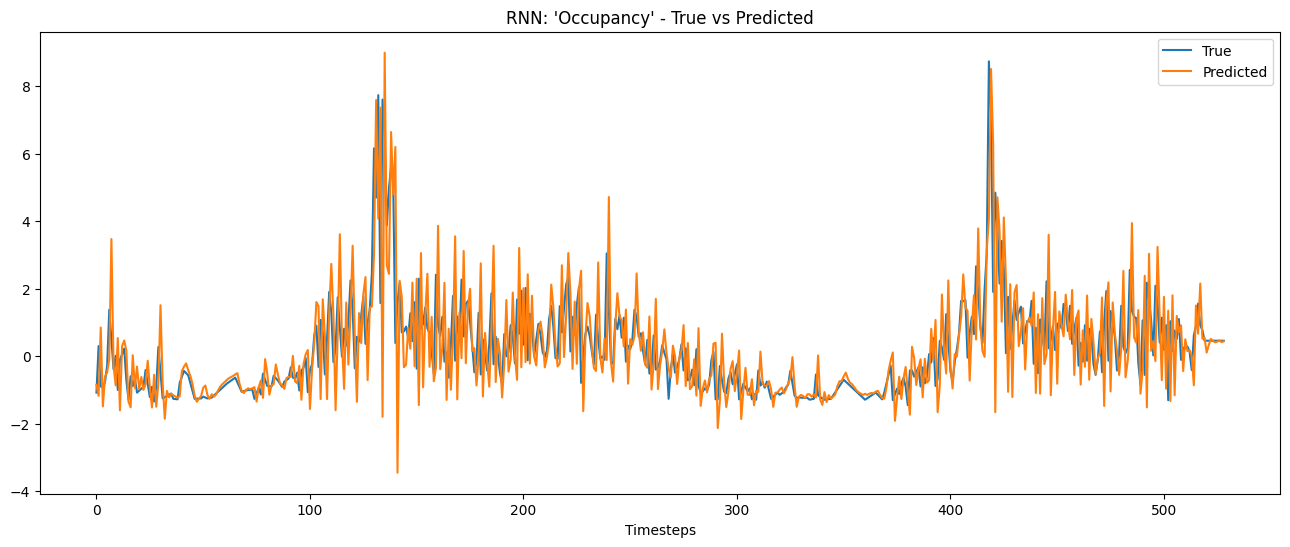

In [ ]:
# Evaluate and plot predictions
yo_pred_rnn = model_RNN_o.predict(Xo_test)
# Rescale to original units
yo_pred_rnn_rescale = scaler_o.inverse_transform(yo_pred_rnn)
# Calculate RMSE and MAE
rnn_rmse_o = np.sqrt(mean_squared_error(yo_test_rescale, yo_pred_rnn_rescale))
rnn_mae_o = mean_absolute_error(yo_test_rescale, yo_pred_rnn_rescale)

print(f'RNN Test: \'Occupancy\' RMSE: {rnn_rmse_o}')
print(f'RNN Test: \'Occupancy\' MAE: {rnn_mae_o}')

plt.figure(figsize=(16,6))
plt.plot(yo_test_rescale, label='True')
plt.plot(yo_pred_rnn_rescale, label='Predicted')
plt.title('RNN: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RNN Test: 'Travel Time' RMSE: 0.20864153718247372
RNN Test: 'Travel Time' MAE: 0.08267131833847541


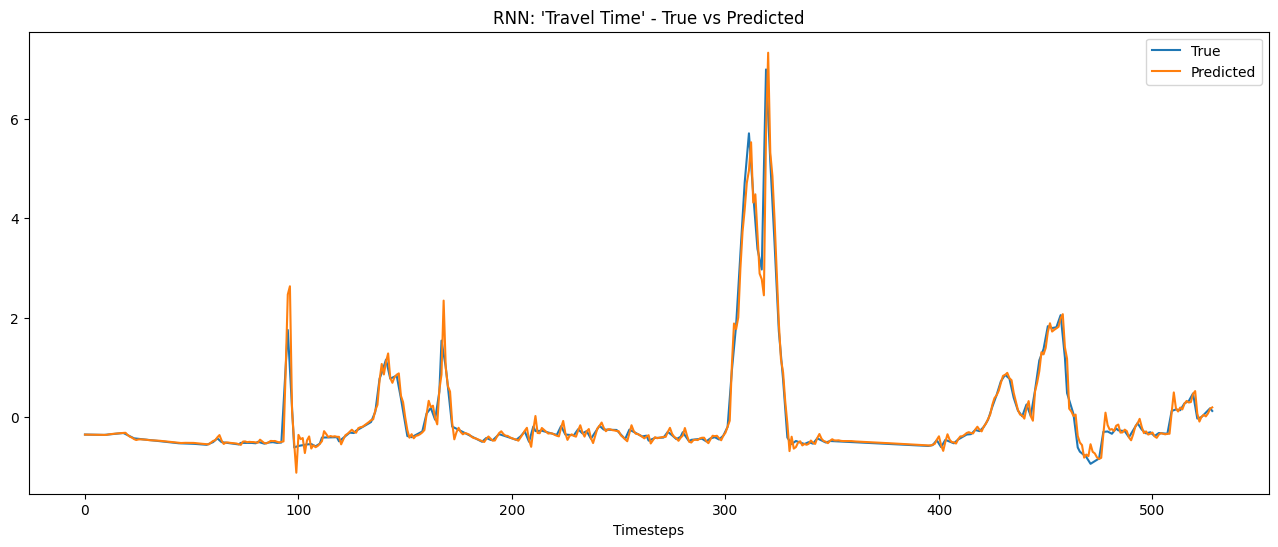

In [ ]:
# Evaluate and plot predictions
yt_pred_rnn = model_RNN_t.predict(Xt_test)
# Rescale to original units
yt_pred_rnn_rescale = scaler_t.inverse_transform(yt_pred_rnn)
# Calculate RMSE and MAE
rnn_rmse_t = np.sqrt(mean_squared_error(yt_test_rescale, yt_pred_rnn_rescale))
rnn_mae_t = mean_absolute_error(yt_test_rescale, yt_pred_rnn_rescale)

print(f'RNN Test: \'Travel Time\' RMSE: {rnn_rmse_t}')
print(f'RNN Test: \'Travel Time\' MAE: {rnn_mae_t}')

plt.figure(figsize=(16,6))
plt.plot(yt_test_rescale, label='True')
plt.plot(yt_pred_rnn_rescale, label='Predicted')
plt.title('RNN: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

### LTSM Model
Make the model:

In [ ]:
# LSTM model
model_LSTM = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(Xs_train.shape[1], 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Optimizer and loss fn
model_LSTM.compile(optimizer='adam', loss='mse')

# Copy models for each variable
model_LSTM_s, model_LSTM_o, model_LSTM_t = model_LSTM, model_LSTM, model_LSTM

# Choose parameters for training
EPOCHS = 60
BATCH_SIZE = 32
VAL_SPLIT = 0.2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Training LSTM models

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.4109 - val_loss: 0.3713
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3617 - val_loss: 0.3102
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3353 - val_loss: 0.3050
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3150 - val_loss: 0.3386
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3097 - val_loss: 0.3123
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2786 - val_loss: 0.2983
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2850 - val_loss: 0.3192
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2932 - val_loss: 0.3127
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3159 - val_loss: 0.3117
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2883 - val_loss: 0.3042
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2750 - val_loss: 0.3088
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2732 - val_l

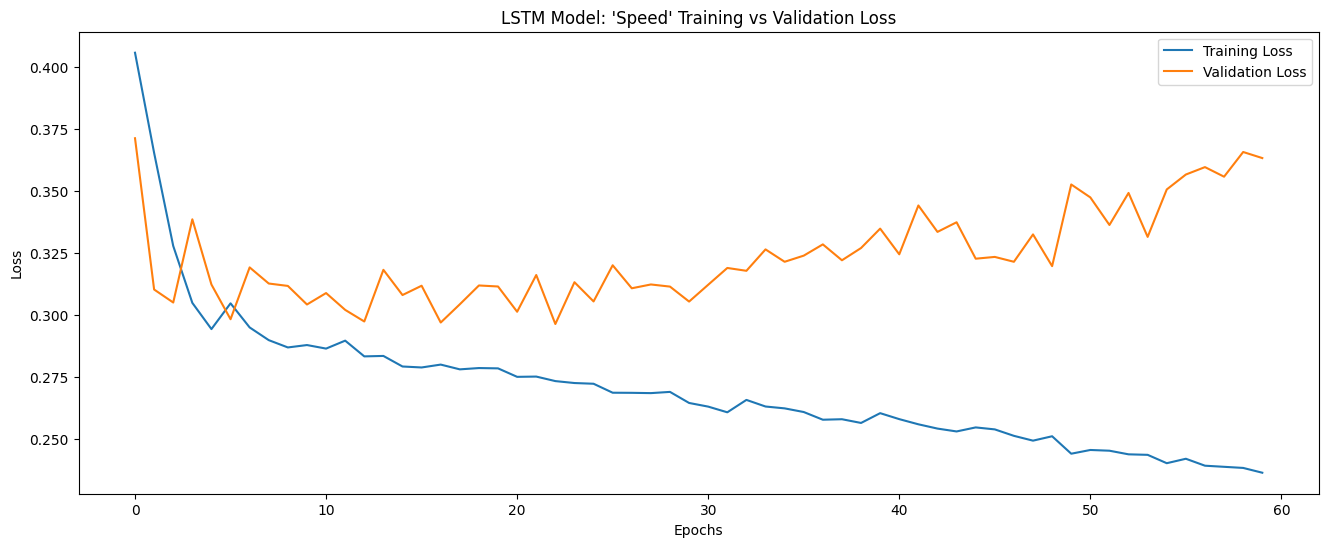

LSTM Training Time for 'Speed': 33.751 seconds


In [ ]:
# Speed data
start_time = time()
lstm_history_speed = model_LSTM_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
lstm_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(lstm_history_speed.history['loss'], label='Training Loss')
plt.plot(lstm_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"LSTM Training Time for \'Speed\': {lstm_time_speed:.3f} seconds")


Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2912 - val_loss: 0.3902
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2557 - val_loss: 0.3938
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2708 - val_loss: 0.3874
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2573 - val_loss: 0.3864
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2487 - val_loss: 0.3908
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2486 - val_loss: 0.3871
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2384 - val_loss: 0.3901
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2377 - val_loss: 0.3878
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2360 - val_loss: 0.3981
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2280 - val_loss: 0.3901
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2418 - val_loss: 0.3894
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2423 - val_l

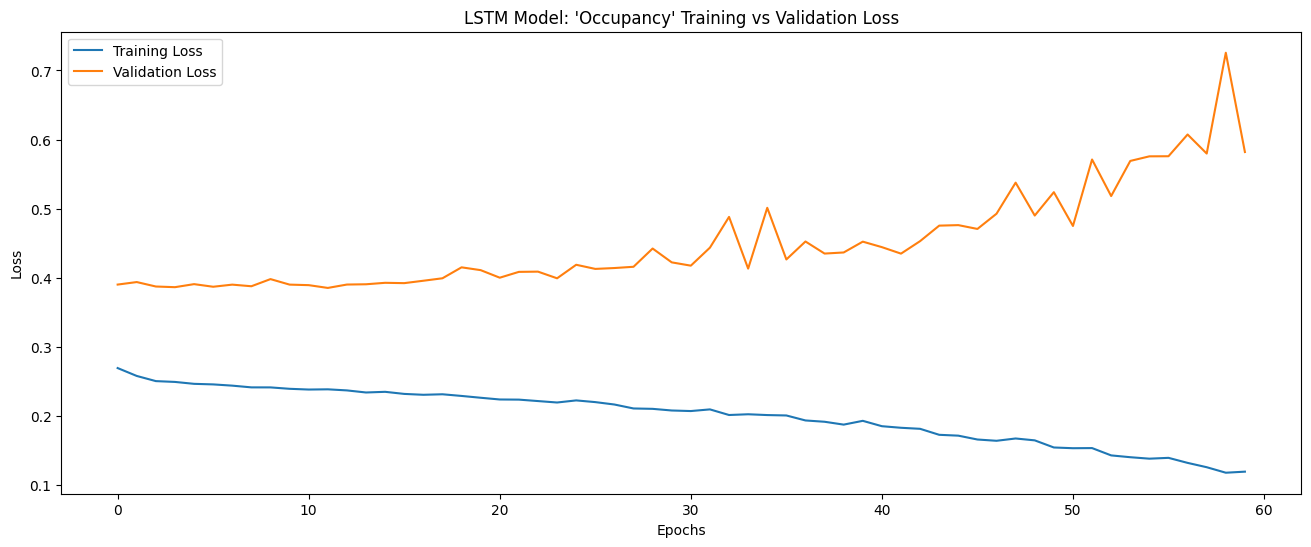

LSTM Training Time for 'Occupancy': 28.103 seconds


In [ ]:
# Occupancy data
start_time = time()
lstm_history_occupancy = model_LSTM_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
lstm_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(lstm_history_occupancy.history['loss'], label='Training Loss')
plt.plot(lstm_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"LSTM Training Time for \'Occupancy\': {lstm_time_occupancy:.3f} seconds")


Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5062 - val_loss: 0.0667
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5886 - val_loss: 0.0418
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1929 - val_loss: 0.0272
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1020 - val_loss: 0.0221
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0580 - val_loss: 0.0187
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0502 - val_loss: 0.0181
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0558 - val_loss: 0.0136
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0914 - val_loss: 0.0198
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0587 - val_loss: 0.0134
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0414 - val_loss: 0.0136
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0364 - val_loss: 0.0146
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - val_lo

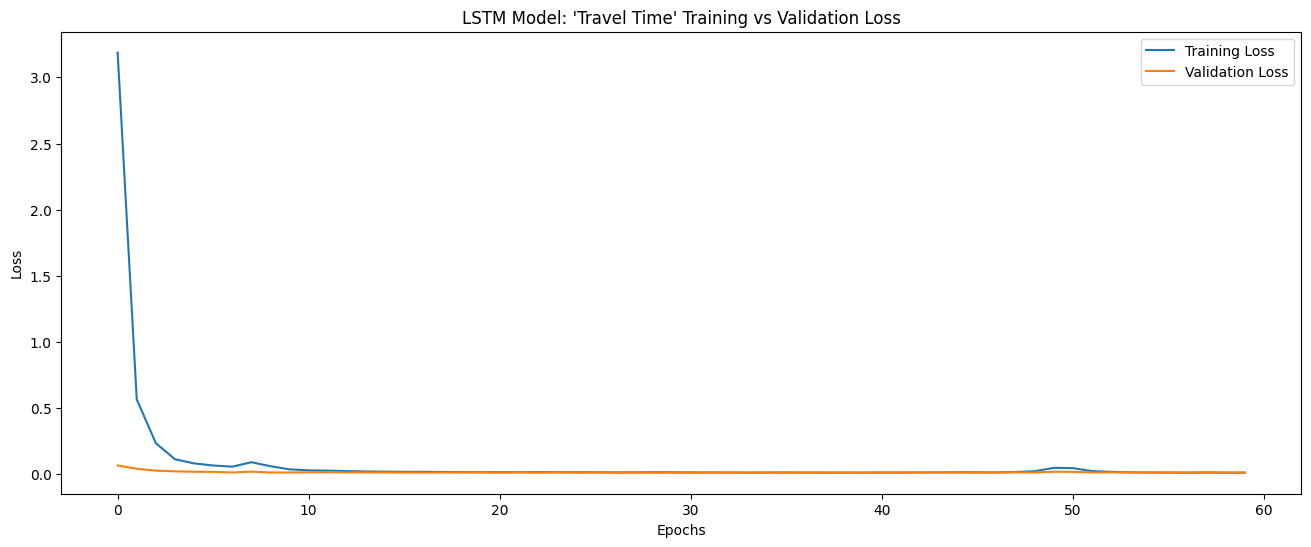

LSTM Training Time for 'Travel Time': 25.729 seconds


In [ ]:
# Travel Time data
start_time = time()
lstm_history_ttime = model_LSTM_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
lstm_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(lstm_history_ttime.history['loss'], label='Training Loss')
plt.plot(lstm_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"LSTM Training Time for \'Travel Time\': {lstm_time_ttime:.3f} seconds")


#### Predicting using LSTM models

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
LSTM Test: 'Speed' RMSE: 1.4214256898802526
LSTM Test: 'Speed' MAE: 0.8730801797368175


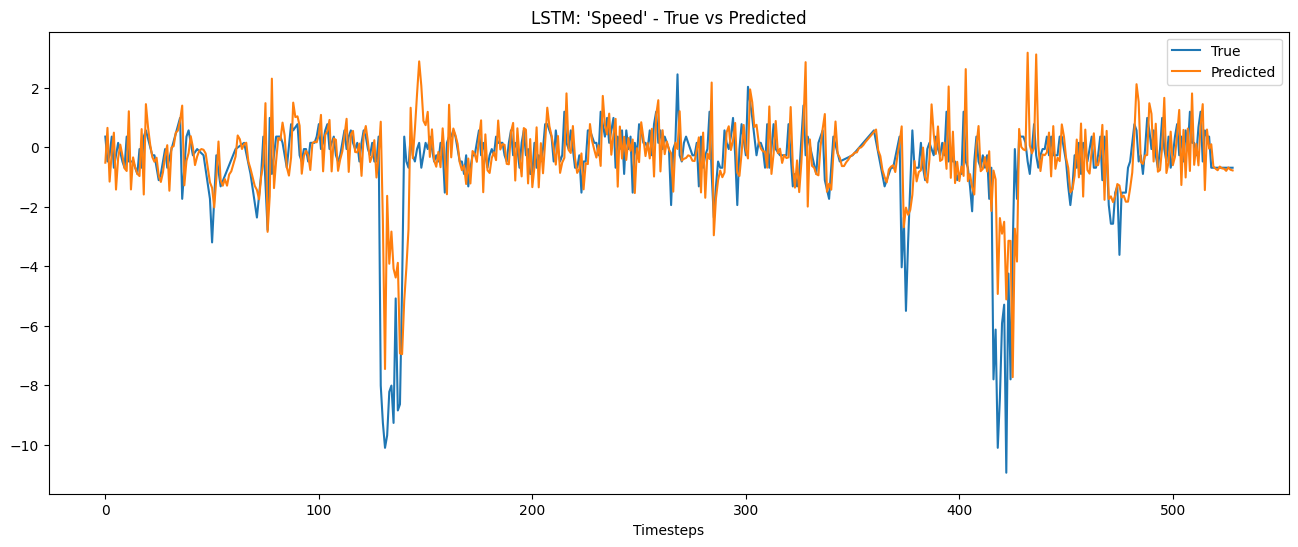

In [ ]:
# Evaluate and plot predictions
ys_pred_lstm = model_LSTM_s.predict(Xs_test)
# Rescale to original units
ys_pred_lstm_rescale = scaler_s.inverse_transform(ys_pred_lstm)
# Calculate RMSE and MAE
lstm_rmse_s = np.sqrt(mean_squared_error(ys_test_rescale, ys_pred_lstm_rescale))
lstm_mae_s = mean_absolute_error(ys_test_rescale, ys_pred_lstm_rescale)

print(f'LSTM Test: \'Speed\' RMSE: {lstm_rmse_s}')
print(f'LSTM Test: \'Speed\' MAE: {lstm_mae_s}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(ys_test_rescale, label='True')
plt.plot(ys_pred_lstm_rescale, label='Predicted')
plt.title('LSTM: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Test: 'Occupancy' RMSE: 1.070937674658457
LSTM Test: 'Occupancy' MAE: 0.6952231784771709


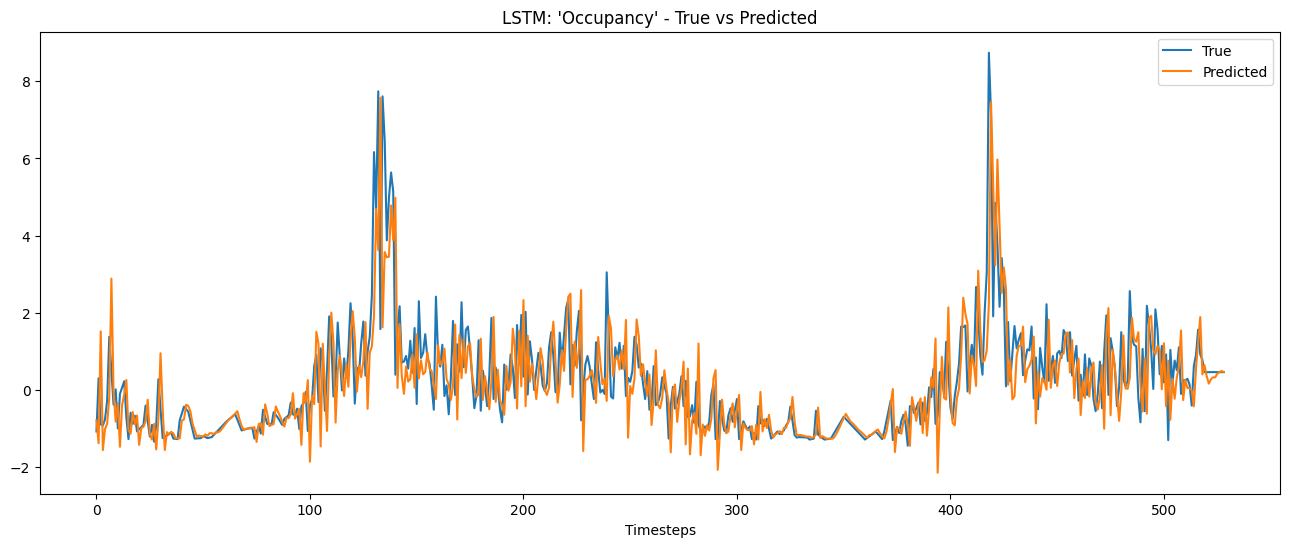

In [ ]:
# Evaluate and plot predictions
yo_pred_lstm = model_LSTM_o.predict(Xo_test)
# Rescale to original units
yo_pred_lstm_rescale = scaler_o.inverse_transform(yo_pred_lstm)
# Calculate RMSE and MAE
lstm_rmse_o = np.sqrt(mean_squared_error(yo_test_rescale, yo_pred_lstm_rescale))
lstm_mae_o = mean_absolute_error(yo_test_rescale, yo_pred_lstm_rescale)

print(f'LSTM Test: \'Occupancy\' RMSE: {lstm_rmse_o}')
print(f'LSTM Test: \'Occupancy\' MAE: {lstm_mae_o}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yo_test_rescale, label='True')
plt.plot(yo_pred_lstm_rescale, label='Predicted')
plt.title('LSTM: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Test: 'Travel Time' RMSE: 0.3179604453820943
LSTM Test: 'Travel Time' MAE: 0.10055335577090223


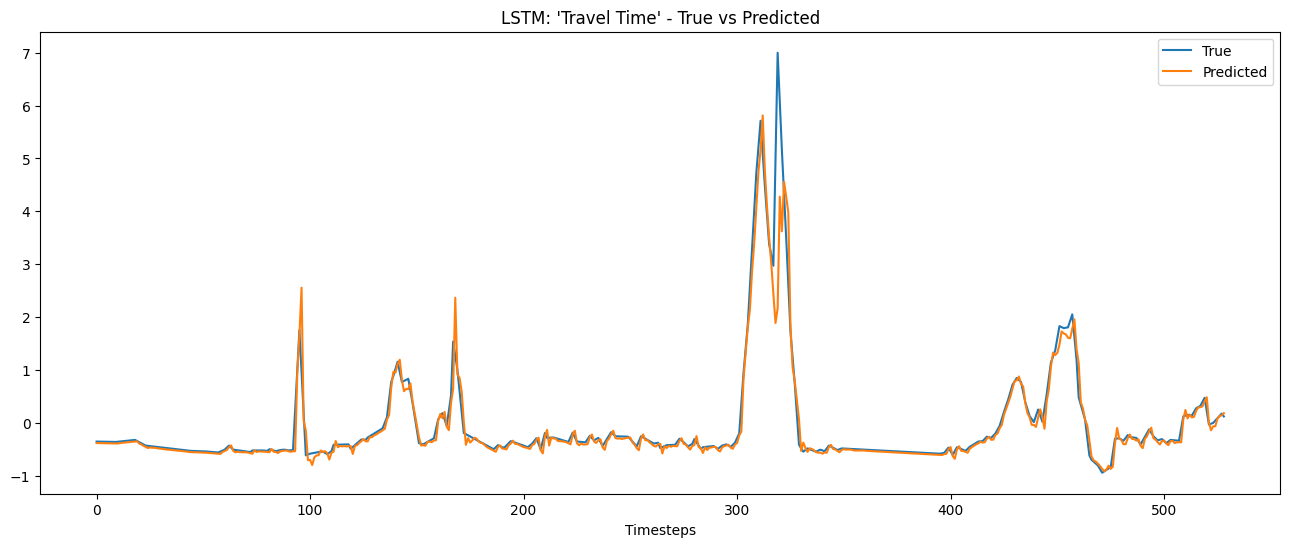

In [ ]:
# Evaluate and plot predictions
yt_pred_lstm = model_LSTM_t.predict(Xt_test)
# Rescale to original units
yt_pred_lstm_rescale = scaler_t.inverse_transform(yt_pred_lstm)
# Calculate RMSE and MAE
lstm_rmse_t = np.sqrt(mean_squared_error(yt_test_rescale, yt_pred_lstm_rescale))
lstm_mae_t = mean_absolute_error(yt_test_rescale, yt_pred_lstm_rescale)

print(f'LSTM Test: \'Travel Time\' RMSE: {lstm_rmse_t}')
print(f'LSTM Test: \'Travel Time\' MAE: {lstm_mae_t}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yt_test_rescale, label='True')
plt.plot(yt_pred_lstm_rescale, label='Predicted')
plt.title('LSTM: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

### GRU Model
Make the model:

In [ ]:
# GRU Model
model_GRU = Sequential()
model_GRU.add(tf.keras.layers.GRU(80, activation='relu', return_sequences=True, input_shape=(Xs_train.shape[1], 1)))
model_GRU.add(tf.keras.layers.GRU(40, activation='relu'))
model_GRU.add(Dense(1))

# Optimizer and loss fn
model_GRU.compile(optimizer='adam', loss='mse')

# Copy models for each variable
model_GRU_s, model_GRU_o, model_GRU_t = model_GRU, model_GRU, model_GRU

# Choose parameters for training
EPOCHS = 60
BATCH_SIZE = 32
VAL_SPLIT = 0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Training GRU models

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.4106 - val_loss: 0.3142
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2897 - val_loss: 0.3213
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2851 - val_loss: 0.3043
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2827 - val_loss: 0.3046
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2903 - val_loss: 0.3140
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2657 - val_loss: 0.3126
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2806 - val_loss: 0.3026
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2837 - val_loss: 0.2959
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2593 - val_loss: 0.2971
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3033 - val_loss: 0.3063
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2908 - val_loss: 0.3063
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2631 - val_l

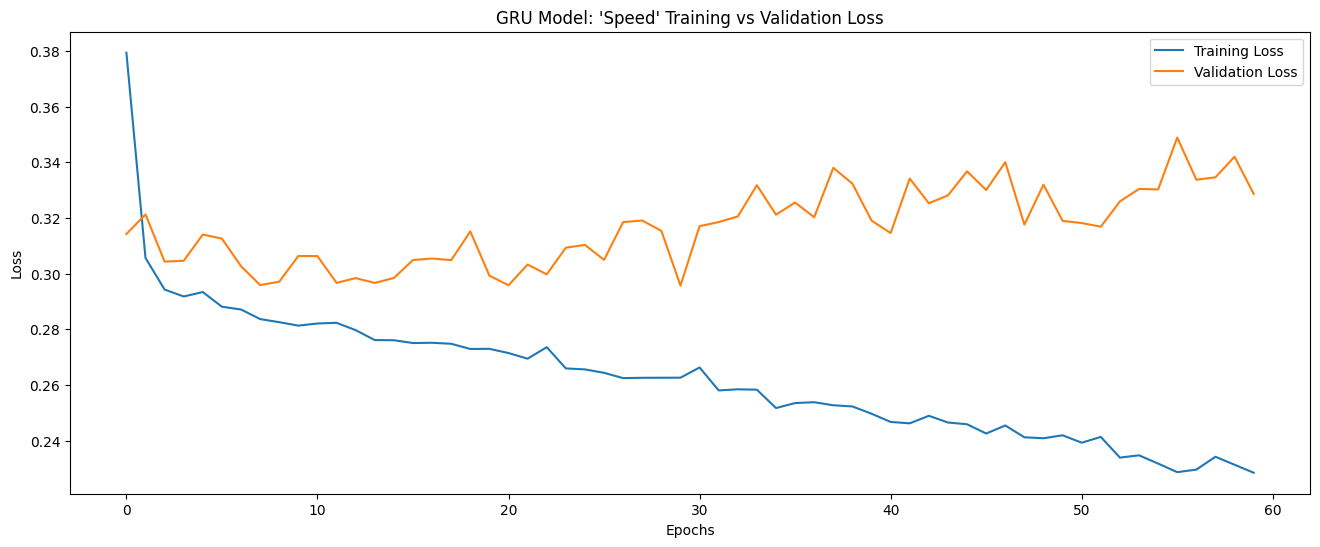

GRU Training Time for 'Speed': 37.663 seconds


In [ ]:
# Speed data
start_time = time()
gru_history_speed = model_GRU_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
gru_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(gru_history_speed.history['loss'], label='Training Loss')
plt.plot(gru_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"GRU Training Time for \'Speed\': {gru_time_speed:.3f} seconds")

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2847 - val_loss: 0.3900
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2366 - val_loss: 0.3900
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2526 - val_loss: 0.3904
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2159 - val_loss: 0.3866
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2246 - val_loss: 0.3913
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2418 - val_loss: 0.3859
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2416 - val_loss: 0.3913
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2297 - val_loss: 0.3928
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2209 - val_loss: 0.3917
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2348 - val_loss: 0.3898
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2217 - val_loss: 0.3903
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2353 - val_l

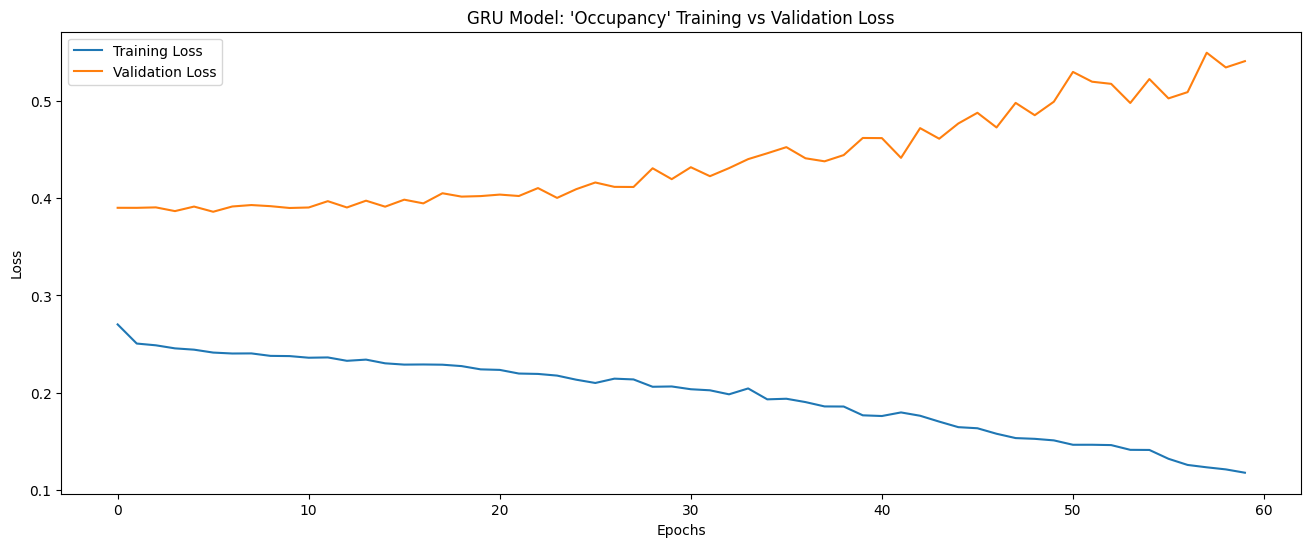

GRU Training Time for 'Occupancy': 29.886 seconds


In [ ]:
# Occupancy data
start_time = time()
gru_history_occupancy = model_GRU_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
gru_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(gru_history_occupancy.history['loss'], label='Training Loss')
plt.plot(gru_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"GRU Training Time for \'Occupancy\': {gru_time_occupancy:.3f} seconds")

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2921 - val_loss: 0.0190
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0391 - val_loss: 0.0158
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0347 - val_loss: 0.0146
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0142
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0125
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - val_loss: 0.0132
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232 - val_loss: 0.0126
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0135
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - val_loss: 0.0123
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0122 - val_loss: 0.0133
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100 - val_lo

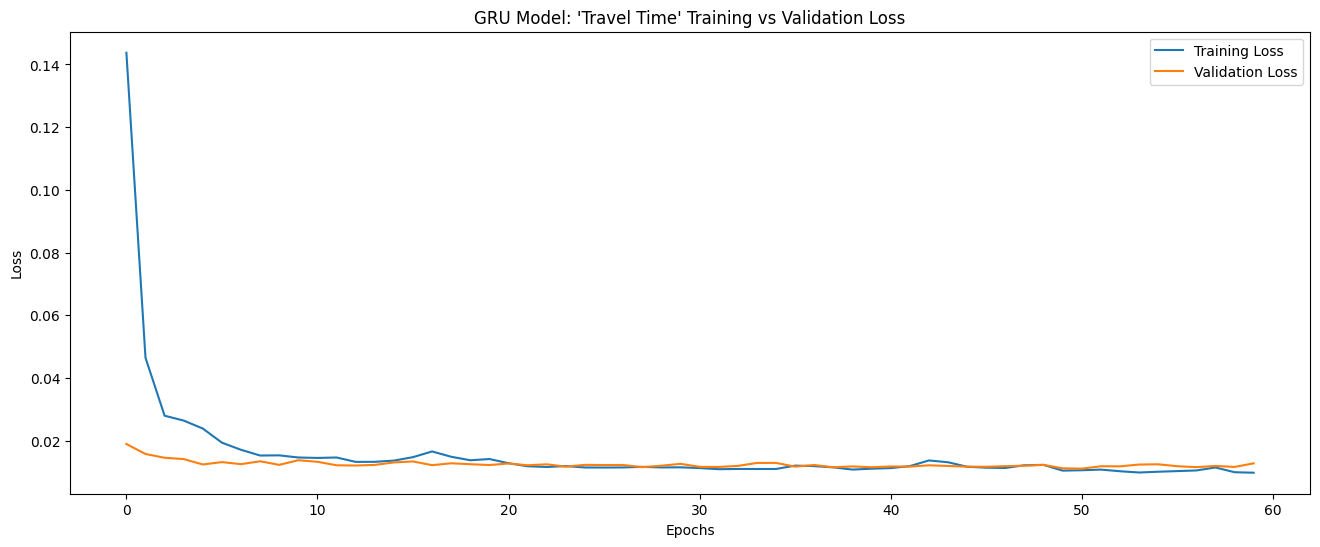

GRU Training Time for 'Travel Time': 29.804 seconds


In [ ]:
# Travel Time data
start_time = time()
gru_history_ttime = model_GRU_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
gru_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(gru_history_ttime.history['loss'], label='Training Loss')
plt.plot(gru_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"GRU Training Time for \'Travel Time\': {gru_time_ttime:.3f} seconds")

#### Predicting using GRU models

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
GRU Test: 'Speed' RMSE: 1.8630379357345574
GRU Test: 'Speed' MAE: 0.9818631702495303


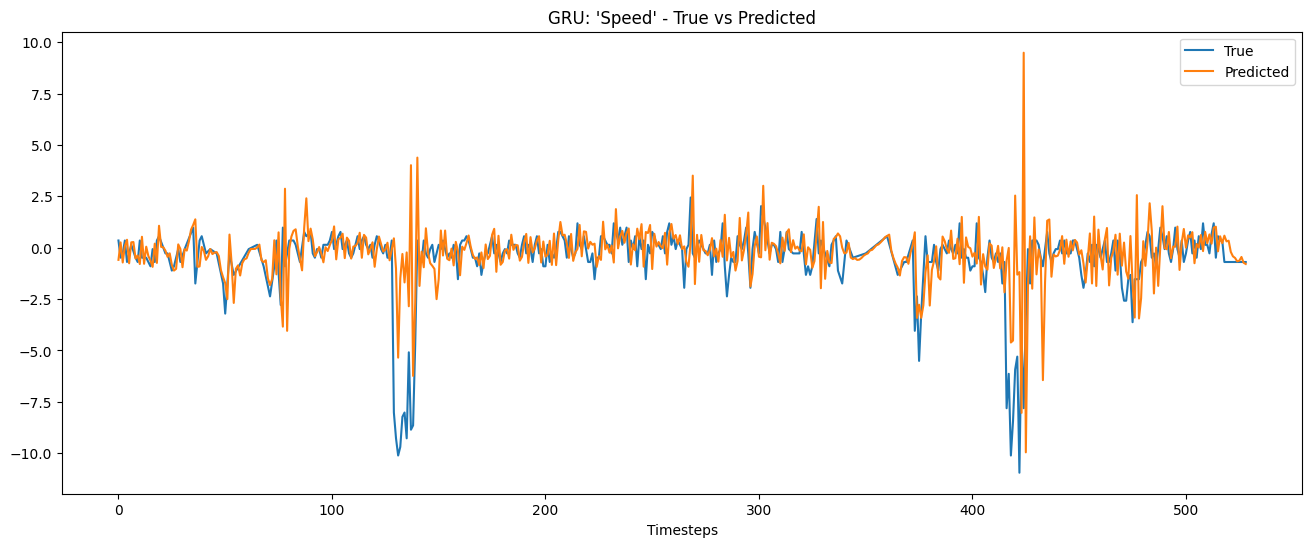

In [ ]:
# Evaluate and plot predictions
ys_pred_gru = model_GRU_s.predict(Xs_test)
# Rescale to original units
ys_pred_gru_rescale = scaler_s.inverse_transform(ys_pred_gru)
# Calculate RMSE and MAE
gru_rmse_s = np.sqrt(mean_squared_error(ys_test_rescale, ys_pred_gru_rescale))
gru_mae_s = mean_absolute_error(ys_test_rescale, ys_pred_gru_rescale)

print(f'GRU Test: \'Speed\' RMSE: {gru_rmse_s}')
print(f'GRU Test: \'Speed\' MAE: {gru_mae_s}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(ys_test_rescale, label='True')
plt.plot(ys_pred_gru_rescale, label='Predicted')
plt.title('GRU: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
GRU Test: 'Occupancy' RMSE: 1.108675863436878
GRU Test: 'Occupancy' MAE: 0.7289911129012369


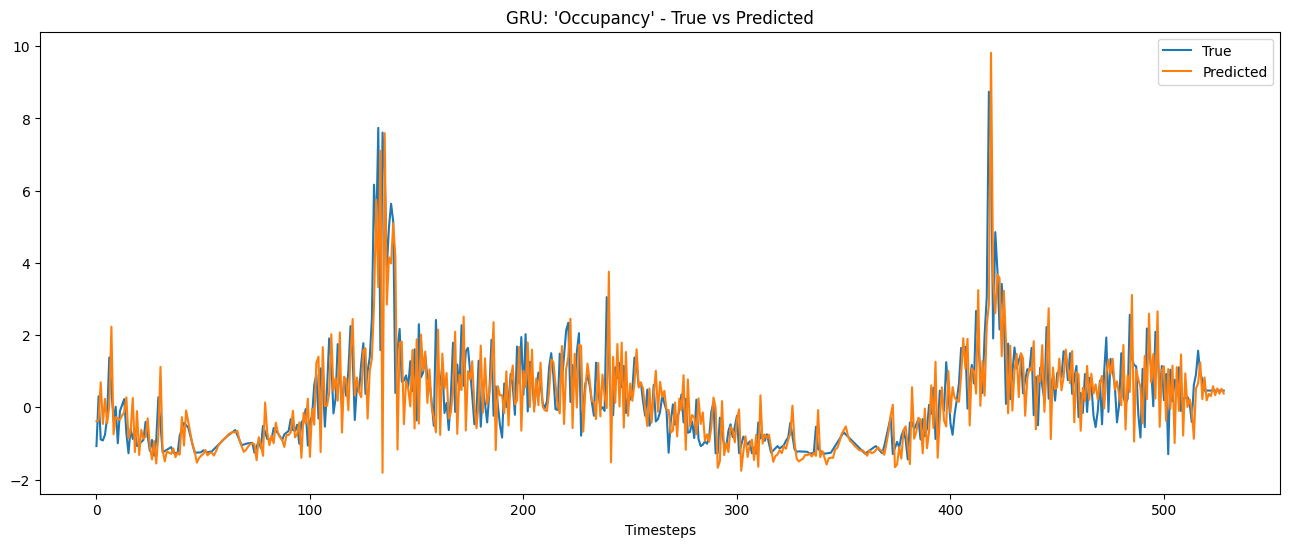

In [ ]:
# Evaluate and plot predictions
yo_pred_gru = model_GRU_o.predict(Xo_test)
# Rescale to original units
yo_pred_gru_rescale = scaler_o.inverse_transform(yo_pred_gru)
# Calculate RMSE and MAE
gru_rmse_o = np.sqrt(mean_squared_error(yo_test_rescale, yo_pred_gru_rescale))
gru_mae_o = mean_absolute_error(yo_test_rescale, yo_pred_gru_rescale)

print(f'GRU Test: \'Occupancy\' RMSE: {gru_rmse_o}')
print(f'GRU Test: \'Occupancy\' MAE: {gru_mae_o}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yo_test_rescale, label='True')
plt.plot(yo_pred_gru_rescale, label='Predicted')
plt.title('GRU: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
GRU Test: 'Travel Time' RMSE: 0.23534488956519703
GRU Test: 'Travel Time' MAE: 0.10136172971373798


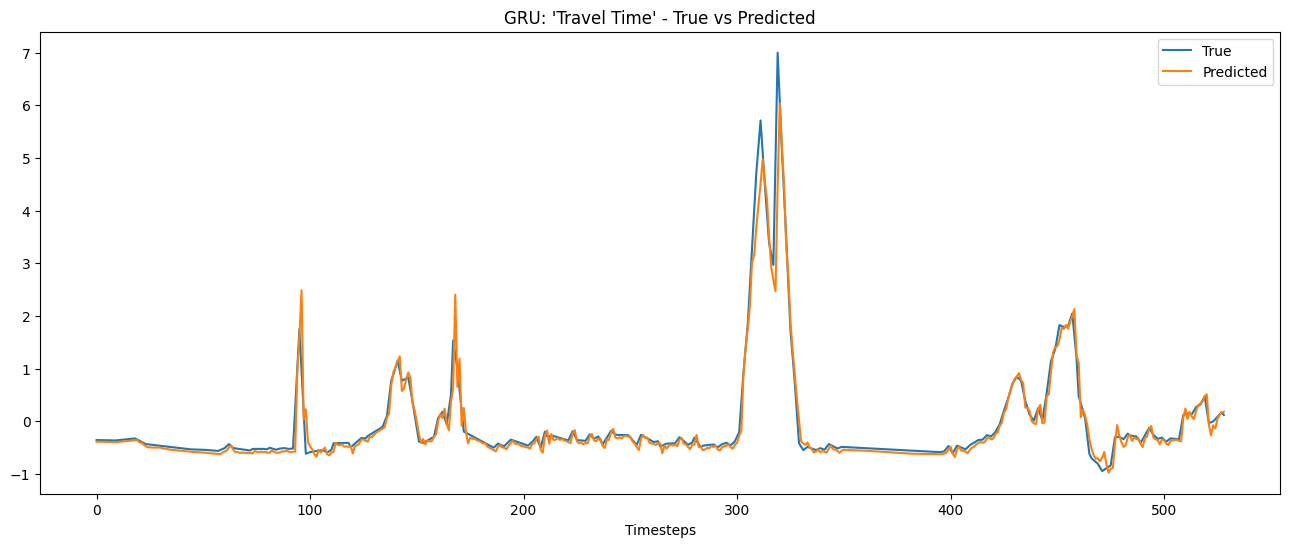

In [ ]:
# Evaluate and plot predictions
yt_pred_gru = model_GRU_t.predict(Xt_test)
# Rescale to original units
yt_pred_gru_rescale = scaler_t.inverse_transform(yt_pred_gru)
# Calculate RMSE and MAE
gru_rmse_t = np.sqrt(mean_squared_error(yt_test_rescale, yt_pred_gru_rescale))
gru_mae_t = mean_absolute_error(yt_test_rescale, yt_pred_gru_rescale)

print(f'GRU Test: \'Travel Time\' RMSE: {gru_rmse_t}')
print(f'GRU Test: \'Travel Time\' MAE: {gru_mae_t}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yt_test_rescale, label='True')
plt.plot(yt_pred_gru_rescale, label='Predicted')
plt.title('GRU: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

## 3. Model Selection and Tuning
- Compare performances and choose a model for each variable
- Hyperparameter tuning our best model(s)

### Model performances

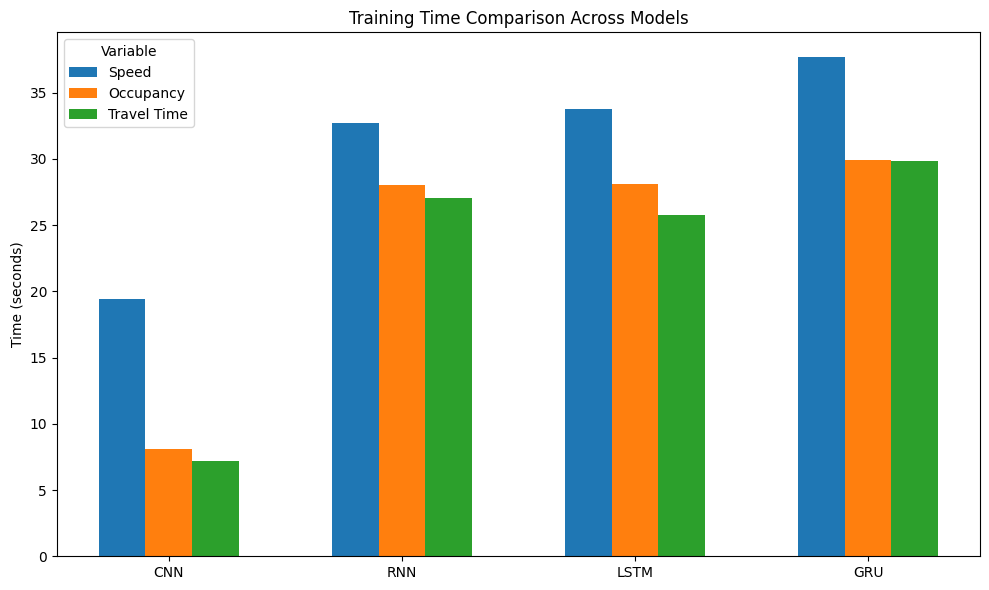

In [ ]:
# Training Time
models = ['CNN', 'RNN', 'LSTM', 'GRU']
metrics = ['Speed', 'Occupancy', 'Travel Time']

times = np.array([
    [cnn_time_speed, cnn_time_occupancy, cnn_time_ttime],  # Performance for CNN
    [rnn_time_speed, rnn_time_occupancy, rnn_time_ttime],  # Performance for RNN
    [lstm_time_speed, lstm_time_occupancy, lstm_time_ttime],   # Performance for LSTM
    [gru_time_speed, gru_time_occupancy, gru_time_ttime] # Performance for GRU
])

# Create plot
x = np.arange(len(models))  # 3 models
bar_width = 0.2   # bar width
offsets = np.arange(len(metrics)) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + offsets[i], times[:, i], width=bar_width, label=metric)
# Display the plot
ax.set_ylabel('Time (seconds)')
ax.set_title('Training Time Comparison Across Models')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Variable')

plt.tight_layout()
plt.show()

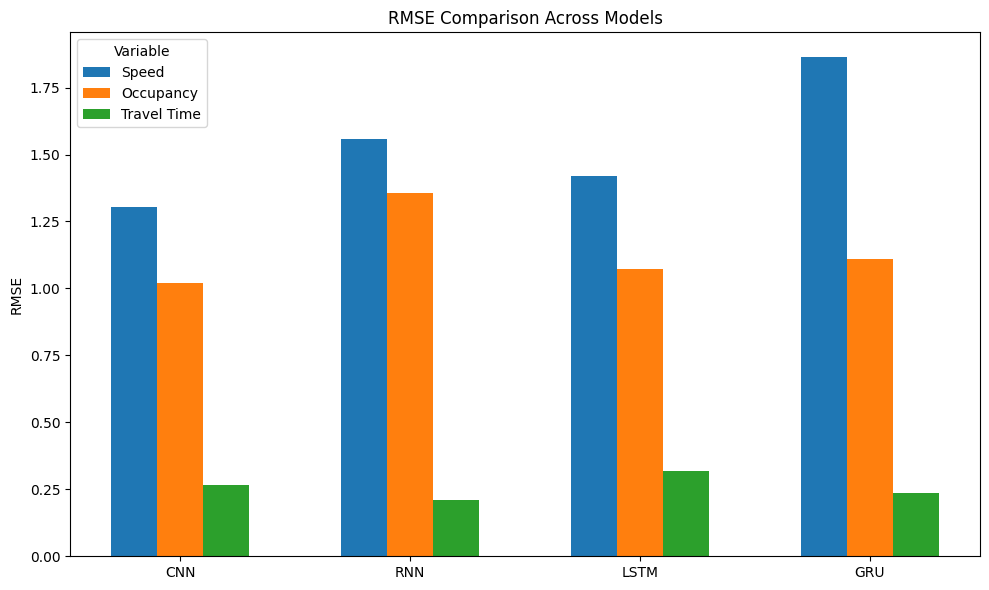

In [ ]:
# RMSE
models = ['CNN', 'RNN', 'LSTM', 'GRU']
metrics = ['Speed', 'Occupancy', 'Travel Time']

times = np.array([
    [cnn_rmse_s, cnn_rmse_o, cnn_rmse_t],  # Performance for CNN
    [rnn_rmse_s, rnn_rmse_o, rnn_rmse_t],  # Performance for RNN
    [lstm_rmse_s, lstm_rmse_o, lstm_rmse_t],   # Performance for LSTM
    [gru_rmse_s, gru_rmse_o, gru_rmse_t] # Performance for GRU
])

# Create plot
x = np.arange(len(models))  # 3 models
bar_width = 0.2   # bar width
offsets = np.arange(len(metrics)) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + offsets[i], times[:, i], width=bar_width, label=metric)
# Display the plot
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison Across Models')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Variable')

plt.tight_layout()
plt.show()

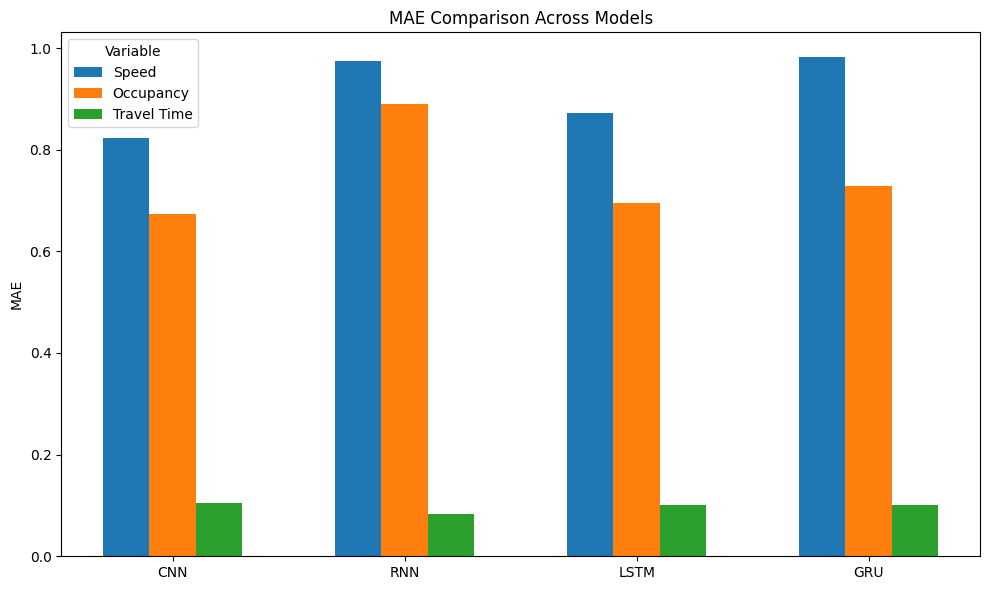

In [ ]:
# MAE
models = ['CNN', 'RNN', 'LSTM', 'GRU']
metrics = ['Speed', 'Occupancy', 'Travel Time']

times = np.array([
    [cnn_mae_s, cnn_mae_o, cnn_mae_t],  # Performance for CNN
    [rnn_mae_s, rnn_mae_o, rnn_mae_t],  # Performance for RNN
    [lstm_mae_s, lstm_mae_o, lstm_mae_t],   # Performance for LSTM
    [gru_mae_s, gru_mae_o, gru_mae_t] # Performance for GRU
])

# Create plot
x = np.arange(len(models))  # 4 models
bar_width = 0.2   # bar width
offsets = np.arange(len(metrics)) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + offsets[i], times[:, i], width=bar_width, label=metric)
# Display the plot
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison Across Models')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Variable')

plt.tight_layout()
plt.show()

### Hyperparameter Tuning

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor

In [ ]:
def create_model_RNN(units=50, activation='relu'):
    model = Sequential([
      SimpleRNN(units, activation=activation, input_shape=(Xo_train.shape[1], 1)),
      Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model
def grid_search(model_type, param_grid, trainX, trainY):
    regressor = KerasRegressor(model_type, verbose=0)
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(trainX, trainY)
    return grid_search.best_estimator_.model_, grid_search.best_params_

# Parameter grid for GridSearchCV
# (Change if needed)
param_grid = {'model__units': [20, 40, 60],
              'batch_size' : [10, 16, 32, 40, 100],
              'epochs' : [10, 20, 50, 80]}

# Train RNN model for 'Speed'
best_model, best_params = grid_search(create_model_RNN, param_grid, Xs_train, ys_train)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


ValueError: Found input variables with inconsistent numbers of samples: [529, 2113]

In [ ]:
# Best Parameters
gs_pred = best_model.predict(Xs_test)
gs_pred_rescale = scaler_s.inverse_transform(gs_pred)
print("Best Hyperparameters:", best_params)

NameError: name 'stacked_model' is not defined

In [ ]:
# Calculate RMSE and MAE
gs_rmse_s = np.sqrt(mean_squared_error(ys_test_rescale, gs_pred_rescale))
gs_mae_s = mean_absolute_error(ys_test_rescale, gs_pred_rescale)

print(f'RNN with Best Params: \'Speed\' RMSE: {gs_rmse_s}')
print(f'RNN with Best Params: \'Speed\' MAE: {gs_mae_s}')

# Plot for Stacked Model
plt.plot(ys_test_rescale, label='Actual')
plt.plot(gs_pred_rescale, label='Predicted')
plt.xlabel('Timesteps')
plt.ylabel('km/h')
plt.legend()
plt.title('Predictions with Best Parameters')
plt.tight_layout()
plt.show()

## 4. Forecasting
- Using best model, forecast for the next 4(?) hours (12*4 timesteps)
- Make interpretations, conclusions for application, etc.

In [ ]:
# From my friend Chad
# ...
def forecast_n_steps(model, input_sequence, n_steps, scaler):
    """
    Forecast n future timesteps using a trained RNN model.

    Args:
    - model: Trained RNN model.
    - input_sequence: The last observed sequence (shape: (1, sequence_length, 1)).
    - n_steps: Number of future timesteps to forecast.
    - scaler: Scaler used to normalize the data during training.

    Returns:
    - forecast: Array of predicted values in the original scale.
    """

    current_sequence = input_sequence.copy()
    forecast = []

    for _ in range(n_steps):
        # Predict next value
        next_prediction = model.predict(current_sequence, verbose=0)
        forecast.append(next_prediction[0, 0])

        # Update sequence: remove the first value and add the new prediction
        current_sequence = np.append(current_sequence[:, 1:, :], [next_prediction], axis=1)

    # Rescale
    forecast_rescale = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_rescale.flatten()


Our data ends on 2015-09-17 17:05:00

Forecast 4 Hours after this

In [ ]:
# Speed

# Use the last sequence from test data as initial input
last_sequence = Xs_test[-1].reshape(1, Xs_test.shape[1], 1)
# Forecast the next 4 hours (12 * 4 = 48 timesteps)
# Use 'best_model' (speed only) from gridsearch
forecast_s = forecast_n_steps(best_model, last_sequence, n_steps=48, scaler=scaler_s)

# New Time range
future_timesteps = pd.date_range(start='2015-09-17 17:05:00', periods=48, freq='5min')

# Plot the forecast of 'Speed'
plt.figure(figsize=(12, 6))
plt.plot(future_timesteps, forecast_s, label='Forecast')
plt.title('Forecast \'Speed\' for Next 4 Hours')
plt.xlabel('Timesteps')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
# Occupancy

# Use the last sequence from test data as initial input
last_sequence = Xo_test[-1].reshape(1, Xo_test.shape[1], 1)
# Forecast the next 4 hours (12 * 4 = 48 timesteps)
# Use Rnn model
forecast_o = forecast_n_steps(model_RNN_o, last_sequence, n_steps=48, scaler=scaler_o)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(future_timesteps, forecast_o, label='Forecast')
plt.title('Forecast \'Occupancy\' for Next 4 Hours')
plt.xlabel('Timesteps')
plt.ylabel('Average Cars')
plt.legend()
plt.show()

In [ ]:
# Travel Time

# Use the last sequence from test data as initial input
last_sequence = Xt_test[-1].reshape(1, Xt_test.shape[1], 1)
# Forecast the next 4 hours (12 * 4 = 48 timesteps)
# Use Rnn model
forecast_t = forecast_n_steps(model_RNN_t, last_sequence, n_steps=48, scaler=scaler_t)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(future_timesteps, forecast_t, label='Forecast')
plt.title('Forecast \'Travel Time\' for Next 4 Hours')
plt.xlabel('Timesteps')
plt.ylabel('Seconds')
plt.legend()
plt.show()

This is our forecast. This is our dream. You cannot change our future. You cannot erase our past.